PBL01_需要予測・在庫最適化　サンプルコード(PBL01_sample_code)   
似ているkaggleのnotebook lag関数やgroupbyを踏まえて, データの整形やり直し

# インポート

In [35]:
import matplotlib.pyplot as plt
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import os
import lightgbm as lgb

import math
import time
import datetime

# 複数のリストの直積（デカルト積）を生成するためのライブラリ
from itertools import product


#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer


from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

import shap
# import xgboost

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')

# pillowをインポート
from PIL import Image
from matplotlib_venn import venn2, venn2_circles

from matplotlib import pyplot
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

# データの読み込み

In [36]:
sales = pd.read_csv('./inputs/sales_history.csv')
train = sales.copy()

cats = pd.read_csv('./inputs/item_categories.csv')
cat_names = pd.read_csv('./inputs/category_names.csv')

test = pd.read_csv('./inputs/test.csv')
sub = pd.read_csv('./inputs/sample_submission.csv', header=None)

## 外部データ

In [37]:
syukujitsu_df = pd.read_csv('./inputs/syukujitsu.csv', encoding="shift-jis")
syukujitsu_df.columns = ["日付", "holiday"]
syukujitsu_df["日付"] = pd.to_datetime(syukujitsu_df["日付"])

# データのマージ

「sales_history.csv」、「item_category.csv」、「category_names.csv」の3つのテーブルを統合する。

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119570 entries, 0 to 1119569
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   日付      1119570 non-null  object 
 1   店舗ID    1119570 non-null  int64  
 2   商品ID    1119570 non-null  int64  
 3   商品価格    1119570 non-null  int64  
 4   売上個数    1119570 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 42.7+ MB


In [39]:
train_merged_data = pd.merge(train, cats, on='商品ID', how='left')
train_merged_data = pd.merge(train_merged_data, cat_names, on='商品カテゴリID', how='left')

train_merged_data.head()

日付  店舗ID     商品ID  商品価格  売上個数  商品カテゴリID   商品カテゴリ名
0  2018-01-01     9  1000001   420   1.0       100  映画 - DVD
1  2018-01-01     6  1000001   420   1.0       100  映画 - DVD
2  2018-01-01    10  1000001   420   1.0       100  映画 - DVD
3  2018-01-01     0  1000017   250   1.0       100  映画 - DVD
4  2018-01-01     1  1000017   250   1.0       100  映画 - DVD

In [40]:
train_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1119570 entries, 0 to 1119569
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   日付        1119570 non-null  object 
 1   店舗ID      1119570 non-null  int64  
 2   商品ID      1119570 non-null  int64  
 3   商品価格      1119570 non-null  int64  
 4   売上個数      1119570 non-null  float64
 5   商品カテゴリID  1119570 non-null  int64  
 6   商品カテゴリ名   1119570 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 68.3+ MB


# 型変換

## train_merged_dataデータ

In [41]:
train_merged_data.head()

日付  店舗ID     商品ID  商品価格  売上個数  商品カテゴリID   商品カテゴリ名
0  2018-01-01     9  1000001   420   1.0       100  映画 - DVD
1  2018-01-01     6  1000001   420   1.0       100  映画 - DVD
2  2018-01-01    10  1000001   420   1.0       100  映画 - DVD
3  2018-01-01     0  1000017   250   1.0       100  映画 - DVD
4  2018-01-01     1  1000017   250   1.0       100  映画 - DVD

In [42]:
train_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1119570 entries, 0 to 1119569
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   日付        1119570 non-null  object 
 1   店舗ID      1119570 non-null  int64  
 2   商品ID      1119570 non-null  int64  
 3   商品価格      1119570 non-null  int64  
 4   売上個数      1119570 non-null  float64
 5   商品カテゴリID  1119570 non-null  int64  
 6   商品カテゴリ名   1119570 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 68.3+ MB


In [43]:
train_merged_data[['店舗ID', '商品ID', '商品カテゴリID']] = train_merged_data[['店舗ID', '商品ID', '商品カテゴリID']].astype(str)

train_merged_data['日付'] = pd.to_datetime(train_merged_data['日付'])

cats[['商品ID', '商品カテゴリID']] = cats[['商品ID', '商品カテゴリID']] .astype(str)
cat_names[['商品カテゴリID']] = cat_names[['商品カテゴリID']] .astype(str)

## テストデータ

In [44]:
test.head()

index     商品ID  店舗ID
0      0  1000001     0
1      1  1000001     1
2      2  1000001     2
3      3  1000001     3
4      4  1000001     4

In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   index   3060 non-null   int64
 1   商品ID    3060 non-null   int64
 2   店舗ID    3060 non-null   int64
dtypes: int64(3)
memory usage: 71.8 KB


In [46]:
test[['index', '店舗ID', '商品ID']] = test[['index', '店舗ID', '商品ID']].astype(str)

# 基本の特徴量の追加

## 祝日情報

In [47]:
train_merged_data = pd.merge(train_merged_data, syukujitsu_df, on="日付", how="left")
train_merged_data["holiday"].fillna(0, inplace=True)
train_merged_data.loc[~(train_merged_data.holiday == 0), "holiday"] = 1
train_merged_data["holiday_cat"] = train_merged_data["holiday"].astype(str)
# del syukujitsu_df

## 日付情報

In [48]:
train_merged_data[['year_cat', 'month_cat', 'day_cat']] = list(map(lambda text:text.split('-'), train_merged_data["日付"].astype(str)))
train_merged_data[['year', 'month', 'day']] = train_merged_data[['year_cat', 'month_cat', 'day_cat']] .astype(int)

In [49]:
def get_day_of_week_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

In [50]:
train_merged_data['weekday_cat'] = train_merged_data['日付'].apply(lambda x : get_day_of_week_jp(x))
train_merged_data['weekday'] = train_merged_data['日付'].apply(lambda x : x.weekday())

## 商品カテゴリー

In [51]:
category = train_merged_data["商品カテゴリ名"].apply(lambda text : text.split('-'))
category_list = list(category)
train_merged_data[["商品カテゴリ_type1", '商品カテゴリ名_tmp']] = category_list

train_merged_data['商品カテゴリ_type2']  = train_merged_data['商品カテゴリ名_tmp'].str.split("_", expand=True)[0]
train_merged_data['商品カテゴリ_type3']  = train_merged_data['商品カテゴリ名_tmp'].str.split("_", expand=True)[1]
train_merged_data = train_merged_data.drop(columns='商品カテゴリ名_tmp')

## 月ブロック

In [52]:
# 「年」と「月」の全組み合わせを作成する
gp_time = train_merged_data.groupby(['year_cat', 'month_cat']).count().reset_index()[['year_cat', 'month_cat']]
# gp_time


時系列をわかりやすくするため、以下のように、「月」単位で通し番号をつけることにする。

- 2018年1月: `0`
- 2018年2月: `1`

...

- 2019年9月: `20`
- 2019年10月: `21`

In [53]:
# カラム名「月ブロック」として、通し番号をつける
gp_time['月ブロック'] = list(range(len(gp_time)))


gp_time = gp_time.append({
    '月ブロック': 22,
    'year_cat': '2019',
    'month_cat': '11',
}, ignore_index=True)

# testデータ用に、評価対象期間である2019年12月(月ブロック: 23)のレコードを追加する
gp_time = gp_time.append({
    '月ブロック': 23,
    'year_cat': '2019',
    'month_cat': '12',
}, ignore_index=True)

# gp_time

In [54]:
# 「月ブロック」カラムをsalesに統合する
train_merged_data = pd.merge(train_merged_data, gp_time, on=['year_cat', 'month_cat'], how='left')
train_merged_data

日付 店舗ID     商品ID  商品価格  売上個数 商品カテゴリID            商品カテゴリ名  \
0       2018-01-01    9  1000001   420   1.0      100           映画 - DVD   
1       2018-01-01    6  1000001   420   1.0      100           映画 - DVD   
2       2018-01-01   10  1000001   420   1.0      100           映画 - DVD   
3       2018-01-01    0  1000017   250   1.0      100           映画 - DVD   
4       2018-01-01    1  1000017   250   1.0      100           映画 - DVD   
...            ...  ...      ...   ...   ...      ...                ...   
1119565 2019-10-31    8  3400006  2700   1.0      340    ゲーム周辺機器 - ゲーム機A   
1119566 2019-10-31    7  3400009  1020   1.0      340    ゲーム周辺機器 - ゲーム機A   
1119567 2019-10-31    7  3400012   510   1.0      340    ゲーム周辺機器 - ゲーム機A   
1119568 2019-10-31    4  3500001   340   1.0      350  本 - オーディオブック_タイプB   
1119569 2019-10-31   13  3500004   420   1.0      350  本 - オーディオブック_タイプB   

        holiday holiday_cat year_cat month_cat day_cat  year  month  day  \
0             1           1     2018        01      01  2018      1    1   
1             1           1     2018        01      01  2018      1    1   
2             1           1     2018        01      01  2018      1    1   
3             1           1     2018        01      01  2018      1    1   
4             1           1     2018        01      01  2018      1    1   
...         ...         ...      ...       ...     ...   ...    ...  ...   
1119565       0           0     2019        10      31  2019     10   31   
1119566       0           0     2019        10      31  2019     10   31   
1119567       0           0     2019        10      31  2019     10   31   
1119568       0           0     2019        10      31  2019     10   31   
1119569       0           0     2019        10      31  2019     10   31   

        weekday_cat  weekday 商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  月ブロック  
0               月曜日        0          映画           DVD         None      0  
1               月曜日        0          映画           DVD         None      0  
2               月曜日        0          映画           DVD         None      0  
3               月曜日        0          映画           DVD         None      0  
4               月曜日        0          映画           DVD         None      0  
...             ...      ...          ...          ...          ...    ...  
1119565         木曜日        3     ゲーム周辺機器         ゲーム機A         None     21  
1119566         木曜日        3     ゲーム周辺機器         ゲーム機A         None     21  
1119567         木曜日        3     ゲーム周辺機器         ゲーム機A         None     21  
1119568         木曜日        3           本      オーディオブック         タイプB     21  
1119569         木曜日        3           本      オーディオブック         タイプB     21  

[1119570 rows x 21 columns]

## sin, cosへの変換

In [55]:
def encode(df, col):
    # この方法だと場合によって最大値が変化するデータでは正確な値は出ない
    # 例：月の日数が30日や31日の場合がある
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df

In [56]:
train_merged_data = encode(train_merged_data, 'month')
train_merged_data = encode(train_merged_data, 'weekday')
train_merged_data = encode(train_merged_data, 'day')

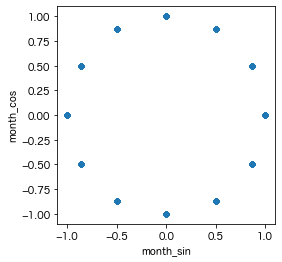

In [57]:
# 例：月の循環性
train_merged_data.plot.scatter('month_sin', 'month_cos').set_aspect('equal')

## 売上金額

In [58]:
train_merged_data['売上金額'] = train_merged_data['商品価格'] * train_merged_data['売上個数']

In [59]:
train_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1119570 entries, 0 to 1119569
Data columns (total 28 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   日付            1119570 non-null  datetime64[ns]
 1   店舗ID          1119570 non-null  object        
 2   商品ID          1119570 non-null  object        
 3   商品価格          1119570 non-null  int64         
 4   売上個数          1119570 non-null  float64       
 5   商品カテゴリID      1119570 non-null  object        
 6   商品カテゴリ名       1119570 non-null  object        
 7   holiday       1119570 non-null  object        
 8   holiday_cat   1119570 non-null  object        
 9   year_cat      1119570 non-null  object        
 10  month_cat     1119570 non-null  object        
 11  day_cat       1119570 non-null  object        
 12  year          1119570 non-null  int64         
 13  month         1119570 non-null  int64         
 14  day           1119570 non-null  int64         
 15

# 外れ値の確認/除外

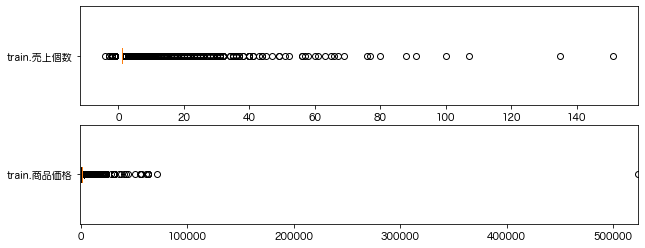

In [60]:
# trainデータにて、「製品の個数」を箱ひげ図で確認する
fig,ax = plt.subplots(2,1,figsize=(10,4))
# 尺度の調整
plt.xlim(-300, train_merged_data.売上個数.max())
# 箱ひげ図を描画
ax[0].boxplot((train_merged_data.売上個数) , labels=['train.売上個数'], vert=False)

# trainデータにて、「商品の価格」を箱ひげ図で確認する
plt.xlim(-1000, train_merged_data.商品価格.max())
ax[1].boxplot((train_merged_data.商品価格) , labels=['train.商品価格'], vert=False)
plt.show()

In [61]:
# 外れ値の除外
train_merged_data = train_merged_data[train_merged_data.商品価格 <= 100000]

# 誤って登録されたゴミデータの確認/修正

## 商品価格0以下

In [62]:
## 0以下の値
train_merged_data[train_merged_data.商品価格 <= 0]

日付 店舗ID     商品ID  商品価格  売上個数 商品カテゴリID      商品カテゴリ名 holiday  \
260519 2018-05-15   14  1300015     0   1.0      130  ゲーム - ゲーム機C       0   
288866 2018-06-01    5  2100019     0   1.0      210  ギフト - ぬいぐるみ       0   
288867 2018-06-01    6  2100019     0   1.0      210  ギフト - ぬいぐるみ       0   
288868 2018-06-01    4  2100019     0   1.0      210  ギフト - ぬいぐるみ       0   
288869 2018-06-01   13  2100020     0   1.0      210  ギフト - ぬいぐるみ       0   
...           ...  ...      ...   ...   ...      ...          ...     ...   
998398 2019-07-27    5  1500208     0   1.0      150  ゲーム - ゲーム機B       0   
998399 2019-07-27    3  1500208     0   1.0      150  ゲーム - ゲーム機B       0   
998401 2019-07-27    7  1500208     0   1.0      150  ゲーム - ゲーム機B       0   
998412 2019-07-27    2  1500229     0   1.0      150  ゲーム - ゲーム機B       0   
998413 2019-07-27    5  1500229     0   1.0      150  ゲーム - ゲーム機B       0   

       holiday_cat year_cat month_cat day_cat  year  month  day weekday_cat  \
260519           0     2018        05      15  2018      5   15         火曜日   
288866           0     2018        06      01  2018      6    1         金曜日   
288867           0     2018        06      01  2018      6    1         金曜日   
288868           0     2018        06      01  2018      6    1         金曜日   
288869           0     2018        06      01  2018      6    1         金曜日   
...            ...      ...       ...     ...   ...    ...  ...         ...   
998398           0     2019        07      27  2019      7   27         土曜日   
998399           0     2019        07      27  2019      7   27         土曜日   
998401           0     2019        07      27  2019      7   27         土曜日   
998412           0     2019        07      27  2019      7   27         土曜日   
998413           0     2019        07      27  2019      7   27         土曜日   

        weekday 商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  月ブロック  month_cos  \
260519        1         ゲーム         ゲーム機C         None      4  -0.866025   
288866        4         ギフト         ぬいぐるみ         None      5  -1.000000   
288867        4         ギフト         ぬいぐるみ         None      5  -1.000000   
288868        4         ギフト         ぬいぐるみ         None      5  -1.000000   
288869        4         ギフト         ぬいぐるみ         None      5  -1.000000   
...         ...          ...          ...          ...    ...        ...   
998398        5         ゲーム         ゲーム機B         None     18  -0.866025   
998399        5         ゲーム         ゲーム機B         None     18  -0.866025   
998401        5         ゲーム         ゲーム機B         None     18  -0.866025   
998412        5         ゲーム         ゲーム機B         None     18  -0.866025   
998413        5         ゲーム         ゲーム機B         None     18  -0.866025   

           month_sin  weekday_cos  weekday_sin   day_cos   day_sin  売上金額  
260519  5.000000e-01          0.5     0.866025 -0.994869  0.101168   0.0  
288866  1.224647e-16         -0.5    -0.866025  0.979530  0.201299   0.0  
288867  1.224647e-16         -0.5    -0.866025  0.979530  0.201299   0.0  
288868  1.224647e-16         -0.5    -0.866025  0.979530  0.201299   0.0  
288869  1.224647e-16         -0.5    -0.866025  0.979530  0.201299   0.0  
...              ...          ...          ...       ...       ...   ...  
998398 -5.000000e-01          0.5    -0.866025  0.688967 -0.724793   0.0  
998399 -5.000000e-01          0.5    -0.866025  0.688967 -0.724793   0.0  
998401 -5.000000e-01          0.5    -0.866025  0.688967 -0.724793   0.0  
998412 -5.000000e-01          0.5    -0.866025  0.688967 -0.724793   0.0  
998413 -5.000000e-01          0.5    -0.866025  0.688967 -0.724793   0.0  

[2271 rows x 28 columns]

In [63]:
train_merged_data[train_merged_data.商品価格 <= 0].商品ID.unique()

array(['1300015', '2100019', '2100020', '2100021', '2100026', '2100027',
       '2100028', '2100032', '2100034', '2100036', '2100037', '2100040',
       '2100041', '2100043', '2100044', '2100045', '2100052', '2100022',
       '2300120', '1100375', '1300273', '1300284', '1300293', '1300317',
       '1500208', '1500229', '1300304', '1500204', '1100302', '1300028'],
      dtype=object)

In [64]:
for index,data in train_merged_data[train_merged_data.商品価格<=0][['月ブロック', '店舗ID', '商品ID', '商品価格', '売上個数']][:20].iterrows():
    print('index', index)
    print(train_merged_data[(train_merged_data.月ブロック==data[0])&(train_merged_data.店舗ID==data[1])&(train_merged_data.商品ID==data[2])][['月ブロック', '店舗ID', '商品ID', '商品価格', '売上個数']])
    print('*'*100)

index 260519
        月ブロック 店舗ID     商品ID  商品価格  売上個数
248070      4   14  1300015  4250   1.0
260519      4   14  1300015     0   1.0
263049      4   14  1300015  2120   1.0
269700      4   14  1300015  2120   1.0
272413      4   14  1300015  2120   1.0
272414      4   14  1300015  2120   1.0
****************************************************************************************************
index 288866
        月ブロック 店舗ID     商品ID  商品価格  売上個数
288866      5    5  2100019     0   1.0
294035      5    5  2100019     0   1.0
294036      5    5  2100019     0   1.0
301584      5    5  2100019     0   1.0
303748      5    5  2100019     0   1.0
307066      5    5  2100019     0   1.0
310959      5    5  2100019     0   1.0
315232      5    5  2100019     0   1.0
317301      5    5  2100019     0   1.0
328443      5    5  2100019     0   1.0
****************************************************************************************************
index 288867
        月ブロック 店舗ID     商品ID  商品価格  売上個数

In [65]:
train_merged_data[train_merged_data.商品ID=='2100019'].商品価格.values

array([1240, 1240, 1240, 1240,  870,  870,  870,  870,  870,  870,  870,
        870,  570,  870,  870,  870,  870,  870,  870,  390,  560,  560,
        560,  560,  560,  560,  520,  560,  560,  520,  560,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  520,
        450,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  520,    0,    0,    0,  520,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,  520,    0,    0,    0,
          0,    0,    0,    0,    0,    0,  520,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,  520,    0,    0,
          0,    0,    0,    0,    0,    0,  560,    0,    0,    0,  560,
          0,    0,    0,  520,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  560,    0,    0,   

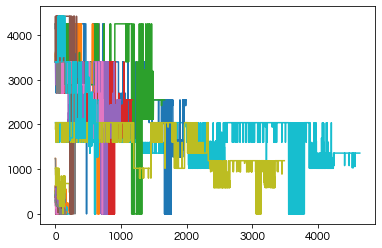

In [66]:
for ID in train_merged_data[train_merged_data.商品価格 <= 0].商品ID.unique():
    plt.plot(train_merged_data[train_merged_data.商品ID==ID].商品価格.values)

In [67]:
idx_tbd = train_merged_data['商品価格'] <= 0
train_merged_data['商品価格_is_0'] = idx_tbd.astype(int)

## 売上個数0以下

In [68]:
# 0以下の値
train_merged_data[train_merged_data.売上個数<0].売上個数.unique()

array([-1., -2., -4., -3.])

In [69]:
train_merged_data[train_merged_data.売上個数<0]

日付 店舗ID     商品ID  商品価格  売上個数 商品カテゴリID       商品カテゴリ名 holiday  \
148     2018-01-01    1  1000487  1440  -1.0      100      映画 - DVD       1   
580     2018-01-01    0  1500008  4760  -1.0      150   ゲーム - ゲーム機B       1   
651     2018-01-01    1  1800005  2090  -1.0      180   ギフト - フィギュア       1   
734     2018-01-01    0  2200029   510  -1.0      220   ゲーム - ゲーム機A       1   
793     2018-01-01    9  2600022  2550  -1.0      260  ギフト - ガジェット類       1   
...            ...  ...      ...   ...   ...      ...           ...     ...   
1118133 2019-10-30   12  1800153  2380  -1.0      180   ギフト - フィギュア       0   
1118181 2019-10-30    6  2000179  2290  -1.0      200  映画 - ブルーレイ3D       0   
1118408 2019-10-31    8  1001872   250  -1.0      100      映画 - DVD       0   
1118435 2019-10-31   13  1002350   250  -1.0      100      映画 - DVD       0   
1118948 2019-10-31    8  1201295   510  -1.0      120      音楽 - その他       0   

        holiday_cat year_cat month_cat day_cat  year  month  day weekday_cat  \
148               1     2018        01      01  2018      1    1         月曜日   
580               1     2018        01      01  2018      1    1         月曜日   
651               1     2018        01      01  2018      1    1         月曜日   
734               1     2018        01      01  2018      1    1         月曜日   
793               1     2018        01      01  2018      1    1         月曜日   
...             ...      ...       ...     ...   ...    ...  ...         ...   
1118133           0     2019        10      30  2019     10   30         水曜日   
1118181           0     2019        10      30  2019     10   30         水曜日   
1118408           0     2019        10      31  2019     10   31         木曜日   
1118435           0     2019        10      31  2019     10   31         木曜日   
1118948           0     2019        10      31  2019     10   31         木曜日   

         weekday 商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  月ブロック  month_cos  \
148            0          映画           DVD         None      0   0.866025   
580            0         ゲーム         ゲーム機B         None      0   0.866025   
651            0         ギフト         フィギュア         None      0   0.866025   
734            0         ゲーム         ゲーム機A         None      0   0.866025   
793            0         ギフト        ガジェット類         None      0   0.866025   
...          ...          ...          ...          ...    ...        ...   
1118133        2         ギフト         フィギュア         None     21   0.500000   
1118181        2          映画       ブルーレイ3D         None     21   0.500000   
1118408        3          映画           DVD         None     21   0.500000   
1118435        3          映画           DVD         None     21   0.500000   
1118948        3          音楽           その他         None     21   0.500000   

         month_sin  weekday_cos   weekday_sin  day_cos       day_sin    売上金額  \
148       0.500000          1.0  0.000000e+00  0.97953  2.012985e-01 -1440.0   
580       0.500000          1.0  0.000000e+00  0.97953  2.012985e-01 -4760.0   
651       0.500000          1.0  0.000000e+00  0.97953  2.012985e-01 -2090.0   
734       0.500000          1.0  0.000000e+00  0.97953  2.012985e-01  -510.0   
793       0.500000          1.0  0.000000e+00  0.97953  2.012985e-01 -2550.0   
...            ...          ...           ...      ...           ...     ...   
1118133  -0.866025         -0.5  8.660254e-01  0.97953 -2.012985e-01 -2380.0   
1118181  -0.866025         -0.5  8.660254e-01  0.97953 -2.012985e-01 -2290.0   
1118408  -0.866025         -1.0  1.224647e-16  1.00000 -2.449294e-16  -250.0   
1118435  -0.866025         -1.0  1.224647e-16  1.00000 -2.449294e-16  -250.0   
1118948  -0.866025         -1.0  1.224647e-16  1.00000 -2.449294e-16  -510.0   

         商品価格_is_0  
148              0  
580              0  
651              0  
734              0  
793              0  
...            ...  
1118133          0  
1118181          0  
1118408          0  
1118435   

In [70]:
for index,data in train_merged_data[train_merged_data.売上個数<0][['月ブロック', '店舗ID', '商品ID', '売上個数']][:3].iterrows():
    print('index', index)
    print(train_merged_data[(train_merged_data.月ブロック==data[0])&(train_merged_data.店舗ID==data[1])&(train_merged_data.商品ID==data[2])][['月ブロック', '店舗ID', '商品ID', '売上個数']])
    print('*'*100)

index 148
     月ブロック 店舗ID     商品ID  売上個数
148      0    1  1000487  -1.0
****************************************************************************************************
index 580
       月ブロック 店舗ID     商品ID  売上個数
580        0    0  1500008  -1.0
6700       0    0  1500008   2.0
6702       0    0  1500008   1.0
6703       0    0  1500008   2.0
9829       0    0  1500008   1.0
15637      0    0  1500008   1.0
20556      0    0  1500008   1.0
23791      0    0  1500008   1.0
40429      0    0  1500008   1.0
43070      0    0  1500008  -1.0
53227      0    0  1500008   1.0
55805      0    0  1500008   1.0
61696      0    0  1500008   1.0
****************************************************************************************************
index 651
      月ブロック 店舗ID     商品ID  売上個数
651       0    1  1800005  -1.0
6943      0    1  1800005   1.0
****************************************************************************************************


同じ年月/店ID/商品IDの中央値をこの誤った値に代入します。

In [71]:
ts = time.time()
with tqdm(total=len(train_merged_data[train_merged_data.売上個数<0])) as pbar:
    for index,data in train_merged_data[train_merged_data.売上個数<0][['月ブロック', '店舗ID', '商品ID', '売上個数']].iterrows():
        median = train_merged_data[(train_merged_data.売上個数>=0) & (train_merged_data.月ブロック==data[0])&(train_merged_data.店舗ID==data[1])&(train_merged_data.商品ID==data[2])].売上個数.median()
        if math.isnan(median):
            train_merged_data.loc[index, '売上個数'] = 0.0
        else:
            train_merged_data.loc[index, '売上個数'] = median

        pbar.update(1)
time.time() - ts

  0%|          | 0/2671 [00:00<?, ?it/s]

225.1102900505066

In [72]:
train_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1119569 entries, 0 to 1119569
Data columns (total 29 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   日付            1119569 non-null  datetime64[ns]
 1   店舗ID          1119569 non-null  object        
 2   商品ID          1119569 non-null  object        
 3   商品価格          1119569 non-null  int64         
 4   売上個数          1119569 non-null  float64       
 5   商品カテゴリID      1119569 non-null  object        
 6   商品カテゴリ名       1119569 non-null  object        
 7   holiday       1119569 non-null  object        
 8   holiday_cat   1119569 non-null  object        
 9   year_cat      1119569 non-null  object        
 10  month_cat     1119569 non-null  object        
 11  day_cat       1119569 non-null  object        
 12  year          1119569 non-null  int64         
 13  month         1119569 non-null  int64         
 14  day           1119569 non-null  int64         
 15

In [73]:
train_merged_data[train_merged_data.売上個数 < 0]

Empty DataFrame
Columns: [日付, 店舗ID, 商品ID, 商品価格, 売上個数, 商品カテゴリID, 商品カテゴリ名, holiday, holiday_cat, year_cat, month_cat, day_cat, year, month, day, weekday_cat, weekday, 商品カテゴリ_type1, 商品カテゴリ_type2, 商品カテゴリ_type3, 月ブロック, month_cos, month_sin, weekday_cos, weekday_sin, day_cos, day_sin, 売上金額, 商品価格_is_0]
Index: []

消えた

# データ確認

In [74]:
train_merged_data.tail()

日付 店舗ID     商品ID  商品価格  売上個数 商品カテゴリID            商品カテゴリ名  \
1119565 2019-10-31    8  3400006  2700   1.0      340    ゲーム周辺機器 - ゲーム機A   
1119566 2019-10-31    7  3400009  1020   1.0      340    ゲーム周辺機器 - ゲーム機A   
1119567 2019-10-31    7  3400012   510   1.0      340    ゲーム周辺機器 - ゲーム機A   
1119568 2019-10-31    4  3500001   340   1.0      350  本 - オーディオブック_タイプB   
1119569 2019-10-31   13  3500004   420   1.0      350  本 - オーディオブック_タイプB   

        holiday holiday_cat year_cat month_cat day_cat  year  month  day  \
1119565       0           0     2019        10      31  2019     10   31   
1119566       0           0     2019        10      31  2019     10   31   
1119567       0           0     2019        10      31  2019     10   31   
1119568       0           0     2019        10      31  2019     10   31   
1119569       0           0     2019        10      31  2019     10   31   

        weekday_cat  weekday 商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  月ブロック  \
1119565         木曜日        3     ゲーム周辺機器         ゲーム機A         None     21   
1119566         木曜日        3     ゲーム周辺機器         ゲーム機A         None     21   
1119567         木曜日        3     ゲーム周辺機器         ゲーム機A         None     21   
1119568         木曜日        3           本      オーディオブック         タイプB     21   
1119569         木曜日        3           本      オーディオブック         タイプB     21   

         month_cos  month_sin  weekday_cos   weekday_sin  day_cos  \
1119565        0.5  -0.866025         -1.0  1.224647e-16      1.0   
1119566        0.5  -0.866025         -1.0  1.224647e-16      1.0   
1119567        0.5  -0.866025         -1.0  1.224647e-16      1.0   
1119568        0.5  -0.866025         -1.0  1.224647e-16      1.0   
1119569        0.5  -0.866025         -1.0  1.224647e-16      1.0   

              day_sin    売上金額  商品価格_is_0  
1119565 -2.449294e-16  2700.0          0  
1119566 -2.449294e-16  1020.0          0  
1119567 -2.449294e-16   510.0          0  
1119568 -2.449294e-16   340.0          0  
1119569 -2.449294e-16   420.0          0

## 型

In [75]:
cat_col = [col for col in train_merged_data.select_dtypes(include=object)]
num_col = [col for col in train_merged_data.select_dtypes(exclude=object)]

# 1日データの保存

In [76]:
train_merged_data.to_pickle('./inputs/train_merged_data.pickle')

In [5]:
# train_merged_data = pd.read_pickle('./inputs/train_merged_data.pickle')

In [77]:
train_merged_data.head()

日付 店舗ID     商品ID  商品価格  売上個数 商品カテゴリID   商品カテゴリ名 holiday holiday_cat  \
0 2018-01-01    9  1000001   420   1.0      100  映画 - DVD       1           1   
1 2018-01-01    6  1000001   420   1.0      100  映画 - DVD       1           1   
2 2018-01-01   10  1000001   420   1.0      100  映画 - DVD       1           1   
3 2018-01-01    0  1000017   250   1.0      100  映画 - DVD       1           1   
4 2018-01-01    1  1000017   250   1.0      100  映画 - DVD       1           1   

  year_cat month_cat day_cat  year  month  day weekday_cat  weekday  \
0     2018        01      01  2018      1    1         月曜日        0   
1     2018        01      01  2018      1    1         月曜日        0   
2     2018        01      01  2018      1    1         月曜日        0   
3     2018        01      01  2018      1    1         月曜日        0   
4     2018        01      01  2018      1    1         月曜日        0   

  商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  月ブロック  month_cos  month_sin  \
0          映画           DVD         None      0   0.866025        0.5   
1          映画           DVD         None      0   0.866025        0.5   
2          映画           DVD         None      0   0.866025        0.5   
3          映画           DVD         None      0   0.866025        0.5   
4          映画           DVD         None      0   0.866025        0.5   

   weekday_cos  weekday_sin  day_cos   day_sin   売上金額  商品価格_is_0  
0          1.0          0.0  0.97953  0.201299  420.0          0  
1          1.0          0.0  0.97953  0.201299  420.0          0  
2          1.0          0.0  0.97953  0.201299  420.0          0  
3          1.0          0.0  0.97953  0.201299  250.0          0  
4          1.0          0.0  0.97953  0.201299  250.0          0

# 前処理

## 「'月'、'商品ID'、 '店舗ID'」の全組み合わせを作成する

salesデータには、売上が0個の場合の履歴が含まれていない。
そのため、モデルに『売上が0個となる』場合を正しく学習させるには、新たにデータを生成する必要がある。
ここでは、「月」×「商品ID」×「店舗ID」の組み合わせを生成し、元のデータと統合することで、『売上が0個となる』場合も含めた売上履歴データの生成を試みる。

In [78]:
all_combination = []

# ['月ブロック',  '店舗ID', '商品ID']の全組み合わせを作成する
columns = ['月ブロック',  '店舗ID', '商品ID']

for i in range(train_merged_data['月ブロック'].nunique()):
    train_block = train_merged_data[train_merged_data['月ブロック']==i]
    all_combination.append(np.array(list(product([i], train_block['店舗ID'].unique(), train_block['商品ID'].unique()))))
    
all_combination = pd.DataFrame(np.vstack(all_combination), columns=columns)
all_combination.sort_values(columns, inplace=True)
all_combination['月ブロック'] = all_combination['月ブロック'].astype(int)

# print(all_combination.info())
all_combination

月ブロック 店舗ID     商品ID
13860       0    0  1000001
14478       0    0  1000002
16299       0    0  1000003
14479       0    0  1000004
14480       0    0  1000005
...       ...  ...      ...
812599      9    9  3500042
812992      9    9  3500043
815731      9    9  3500045
812600      9    9  3500047
813997      9    9  3500053

[1648908 rows x 3 columns]

## 月ごとの目的変数(売上)を集計する

ここからは、モデルの学習を行うためのデータセットの作成作業に入る。
『各店舗』×『各商品』の組み合わせについて、『2019年12月の1ヶ月間』における『合計売上個数』を予測する
というのが今回のタスクであるため、学習用データをそれに従って再構成する。

In [79]:
# 「月ブロック」「商品ID」「店舗ID」でグルーピングし、売上個数の合計を取る
gp_month = train_merged_data.groupby(['月ブロック',  '店舗ID', '商品ID']).agg({'売上個数': np.sum}).reset_index()
gp_month

月ブロック 店舗ID     商品ID  売上個数
0           0    0  1000001   6.0
1           0    0  1000002   2.0
2           0    0  1000004   1.0
3           0    0  1000005   8.0
4           0    0  1000006   2.0
...       ...  ...      ...   ...
495128     21    9  3400006   2.0
495129     21    9  3400012   1.0
495130     21    9  3500002   1.0
495131     21    9  3500003   1.0
495132     21    9  3500004   1.0

[495133 rows x 4 columns]

In [80]:
# all_combinationに売上履歴データを追加する
all_train = pd.merge(all_combination, gp_month, on=['月ブロック', '商品ID', '店舗ID'], how='left')

# 売上個数がNaNとなっている箇所は、売上個数0個として値を埋める
all_train['売上個数'] = all_train['売上個数'].fillna(0).astype(np.float16) # 0で穴埋めする, # 型のキャスト

In [81]:
all_train

月ブロック 店舗ID     商品ID  売上個数
0            0    0  1000001   6.0
1            0    0  1000002   2.0
2            0    0  1000003   0.0
3            0    0  1000004   1.0
4            0    0  1000005   8.0
...        ...  ...      ...   ...
1648903      9    9  3500042   0.0
1648904      9    9  3500043   0.0
1648905      9    9  3500045   0.0
1648906      9    9  3500047   0.0
1648907      9    9  3500053   0.0

[1648908 rows x 4 columns]

# テストデータ(前処理を行う)¶

## テストデータの作成

In [23]:
new_test11 = test.copy()
# 評価対象期間が2019年11月(月ブロック: 22)であるという情報を追加
new_test11['月ブロック'] = 22
new_test11 = new_test11.drop(columns = 'index')
dummy_month11 = pd.read_pickle('./inputs/dummy_sales_month11.pickle')
dummy_month11 = dummy_month11.drop(0, axis=1)
new_test11 = pd.merge(new_test11, dummy_month11, right_index=True, left_index=True, how='left')
new_test11 = new_test11.rename(columns={1:'売上個数'})
del dummy_month11
new_test11

In [24]:
new_test12 = test.copy()
# 評価対象期間が2019年12月(月ブロック: 23)であるという情報を追加
new_test12['月ブロック'] = 23
new_test12 = new_test12.drop(columns = 'index')
new_test12

商品ID  店舗ID  月ブロック
0     1000001     0     23
1     1000001     1     23
2     1000001     2     23
3     1000001     3     23
4     1000001     4     23
...       ...   ...    ...
3055  3500001    13     23
3056  3500001    14     23
3057  3500001    15     23
3058  3500001    16     23
3059  3500001    17     23

[3060 rows x 3 columns]

## 学習データとテストデータを縦に結合

In [26]:
# all_train = pd.concat([all_train, new_test11])
dataset = pd.concat([all_train, new_test12])
dataset

月ブロック 店舗ID     商品ID  商品価格sum  商品価格mean  売上個数  売上個数mean  売上個数count
0         0    0  1000001   2100.0     420.0   6.0  1.200195        5.0
1         0    0  1000002    500.0     250.0   2.0  1.000000        2.0
2         0    0  1000003      0.0       0.0   0.0  0.000000        0.0
3         0    0  1000004    120.0     120.0   1.0  1.000000        1.0
4         0    0  1000005   1760.0     220.0   8.0  1.000000        8.0
...     ...  ...      ...      ...       ...   ...       ...        ...
3055     23   13  3500001      NaN       NaN   NaN       NaN        NaN
3056     23   14  3500001      NaN       NaN   NaN       NaN        NaN
3057     23   15  3500001      NaN       NaN   NaN       NaN        NaN
3058     23   16  3500001      NaN       NaN   NaN       NaN        NaN
3059     23   17  3500001      NaN       NaN   NaN       NaN        NaN

[1651968 rows x 8 columns]

# 特徴量生成

## 変換・追加型の特徴量

### 「年・月」情報の追加

In [31]:
dataset_addfeature = pd.merge(dataset, gp_time, on='月ブロック', how='left')

In [32]:
dataset_addfeature

月ブロック 店舗ID     商品ID  商品価格sum  商品価格mean  売上個数  売上個数mean  売上個数count  \
0            0    0  1000001   2100.0     420.0   6.0  1.200195        5.0   
1            0    0  1000002    500.0     250.0   2.0  1.000000        2.0   
2            0    0  1000003      0.0       0.0   0.0  0.000000        0.0   
3            0    0  1000004    120.0     120.0   1.0  1.000000        1.0   
4            0    0  1000005   1760.0     220.0   8.0  1.000000        8.0   
...        ...  ...      ...      ...       ...   ...       ...        ...   
1651963     23   13  3500001      NaN       NaN   NaN       NaN        NaN   
1651964     23   14  3500001      NaN       NaN   NaN       NaN        NaN   
1651965     23   15  3500001      NaN       NaN   NaN       NaN        NaN   
1651966     23   16  3500001      NaN       NaN   NaN       NaN        NaN   
1651967     23   17  3500001      NaN       NaN   NaN       NaN        NaN   

        year_cat month_cat  
0           2018        01  
1           2018        01  
2           2018        01  
3           2018        01  
4           2018        01  
...          ...       ...  
1651963     2019        12  
1651964     2019        12  
1651965     2019        12  
1651966     2019        12  
1651967     2019        12  

[1651968 rows x 10 columns]

### 文字列データを数値データに直す

In [53]:
dataset_addfeature['year'] = dataset_addfeature['year_cat'].astype(int)
dataset_addfeature['month'] = dataset_addfeature['month_cat'].astype(int)

### 月ブロック_catを追加

In [54]:
dataset_addfeature['月ブロック_cat'] = dataset_addfeature['月ブロック'].astype(str)

### 「祝日の数」情報の追加

In [55]:
syukujitsu_df = syukujitsu_df[syukujitsu_df['日付'] >= '2018-01-01']
syukujitsu_df[['year_cat', 'month_cat', 'day_cat']] = list(map(lambda text:text.split('-'), syukujitsu_df["日付"].astype(str)))
syukujitsu_df[['year', 'month', 'day']] = syukujitsu_df[['year_cat', 'month_cat', 'day_cat']] .astype(int)
syukujitsu_df['holiday_flag'] = 1

group = syukujitsu_df.groupby(['year_cat', 'month_cat']).agg({'holiday_flag': np.sum}).reset_index()

In [56]:
dataset_addfeature = pd.merge(dataset_addfeature, group, on=['year_cat', 'month_cat'], how='left')

In [57]:
dataset_addfeature = dataset_addfeature.fillna({'holiday_flag': 0})
dataset_addfeature['holiday_flag'] = dataset_addfeature['holiday_flag'].astype(int)
dataset_addfeature.rename(columns={'holiday_flag':'holiday_cnt'}, inplace=True)

In [58]:
dataset_addfeature

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  
0                  2  
1                  2  
2                  2  
3                  2  
4                  2  
...              ...  
1655023            0  
1655024            0  
1655025            0  
1655026            0  
1655027            0  

[1655028 rows x 10 columns]

### sin, cosへの変換

In [59]:
def encode(df, col):
    # この方法だと場合によって最大値が変化するデータでは正確な値は出ない
    # 例：月の日数が30日や31日の場合がある
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df

In [60]:
dataset_addfeature = encode(dataset_addfeature, 'month')

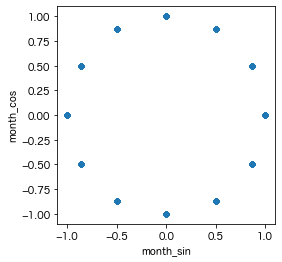

In [61]:
# 例：月の循環性
dataset_addfeature.plot.scatter('month_sin', 'month_cos').set_aspect('equal')

### 「商品カテゴリID」「商品カテゴリ名」情報の追加

In [62]:
ts = time.time()
dataset_addfeature = pd.merge(dataset_addfeature, cats, on='商品ID', how='left')
dataset_addfeature = pd.merge(dataset_addfeature, cat_names, on='商品カテゴリID', how='left')

category = dataset_addfeature["商品カテゴリ名"].apply(lambda text : text.split('-'))
category_list = list(category)
dataset_addfeature[["商品カテゴリ_type1", '商品カテゴリ名_tmp']] = category_list

dataset_addfeature['商品カテゴリ_type2']  = dataset_addfeature['商品カテゴリ名_tmp'].str.split("_", expand=True)[0]
dataset_addfeature['商品カテゴリ_type3']  = dataset_addfeature['商品カテゴリ名_tmp'].str.split("_", expand=True)[1]
dataset_addfeature = dataset_addfeature.drop(columns='商品カテゴリ名_tmp')
time.time() - ts

7.13873815536499

In [63]:
item_categories_addname = pd.read_pickle('./inputs/item_categories_addname.pickle')
category = item_categories_addname["商品カテゴリ名"].apply(lambda text : text.split('-'))
category_list = list(category)
item_categories_addname[["商品カテゴリ_type1", '商品カテゴリ名_tmp']] = category_list
item_categories_addname['商品カテゴリ_type2']  = item_categories_addname['商品カテゴリ名_tmp'].str.split("_", expand=True)[0]
item_categories_addname['商品カテゴリ_type3']  = item_categories_addname['商品カテゴリ名_tmp'].str.split("_", expand=True)[1]
item_categories_addname = item_categories_addname.drop(columns='商品カテゴリ名_tmp')

In [64]:
group = item_categories_addname.groupby(['商品カテゴリ名']).agg({'商品ID':['count']})
group.columns = ['カテゴリ内_商品数']
group.reset_index(inplace=True)
dataset_addfeature = pd.merge(dataset_addfeature, group, on='商品カテゴリ名', how='left')

In [65]:
group = item_categories_addname.groupby(['商品カテゴリ_type1']).agg({'商品ID':['count']})
group.columns = ['カテゴリtype1内_商品数']
group.reset_index(inplace=True)
dataset_addfeature = pd.merge(dataset_addfeature, group, on='商品カテゴリ_type1', how='left')

In [66]:
group = item_categories_addname.groupby(['商品カテゴリ_type2']).agg({'商品ID':['count']})
group.columns = ['カテゴリtype2内_商品数']
group.reset_index(inplace=True)
dataset_addfeature = pd.merge(dataset_addfeature, group, on='商品カテゴリ_type2', how='left')

In [67]:
group = item_categories_addname.groupby(['商品カテゴリ_type3']).agg({'商品ID':['count']})
group.columns = ['カテゴリtype3内_商品数']
group.reset_index(inplace=True)
dataset_addfeature = pd.merge(dataset_addfeature, group, on='商品カテゴリ_type3', how='left')

In [68]:
del item_categories_addname

### あるワードがカテゴリ内に入っているかどうか

In [69]:
dataset_addfeature['商品カテゴリ名_contains_ゲーム'] = np.where(dataset_addfeature['商品カテゴリ名'].str.contains('ゲーム'), 1, 0)
dataset_addfeature['商品カテゴリ名_contains_PC'] = np.where(dataset_addfeature['商品カテゴリ名'].str.contains('PC'), 1, 0)

In [70]:
dataset_addfeature

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0  
...                      ...  
1655023                    0  
1655024                    0  
1655025                    0  
1655026                    0  
1655027                    0  

[1655028 rows x 23 columns]

## 集約型の特徴量

### ラグ特徴量の作成

昨年度同月の売上個数が今年度の売上個数の予測に役立つのではないかという仮説のもとに、ラグ特徴量を生成する  
ここでは、月ブロックを1年分(12)ずらした上でデータを統合するという方法を取る。

In [71]:
def lag_feature(df, lags, col):
    tmp = df[['月ブロック','商品ID','店舗ID',col]]
    for i in tqdm(lags):
        shifted = tmp.copy()
        # 列名の更新
        shifted.columns = ['月ブロック','商品ID','店舗ID', col+'_lag_'+str(i)]
        shifted['月ブロック'] += i
        df = pd.merge(df, shifted, on=['月ブロック','商品ID','店舗ID'], how='left')
    return df

In [72]:
lags = [1,2,3,4,5,6,7,8,9,10,11,12]

#### Traget lags(nヶ月前の売上個数を特徴量に追加)

In [73]:
ts = time.time()
# lagsに格納された値のヶ月前の売上個数を特量量として追加する
dataset_addfeature_lag = lag_feature(dataset_addfeature, lags, '売上個数')
time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

10.286516189575195

In [74]:
dataset_addfeature_lag

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
0                          0         NaN         NaN         NaN         NaN   
1                          0         NaN         NaN         NaN         NaN   
2                          0         NaN         NaN         NaN         NaN   
3                          0         NaN         NaN         NaN         NaN   
4                

#### 売上個数の平均値 標準値 最大値 最小値 のラグ特徴量

##### 月ブロック で絞った 月次売上個数のlag

In [75]:
ts = time.time()
group = dataset_addfeature_lag.groupby(['月ブロック']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[1:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)
time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

49.80083203315735

In [76]:
dataset_addfeature_lag

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
0                          0         NaN         NaN         NaN         NaN   
1                          0         NaN         NaN         NaN         NaN   
2                          0         NaN         NaN         NaN         NaN   
3                          0         NaN         NaN         NaN         NaN   
4                

##### 月ブロック と 商品ID で絞った 月次売上個数 のlag

In [77]:
ts = time.time()

group = dataset_addfeature_lag.groupby(['月ブロック', '商品ID']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_item".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[2:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','商品ID'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)

time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

61.05930304527283

In [78]:
dataset_addfeature_lag

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
0                          0         NaN         NaN         NaN         NaN   
1                          0         NaN         NaN         NaN         NaN   
2                          0         NaN         NaN         NaN         NaN   
3                          0         NaN         NaN         NaN         NaN   
4                

##### 月ブロック と 店舗ID で絞った 月次売上個数 のlag

In [79]:
ts = time.time()

group = dataset_addfeature_lag.groupby(['月ブロック', '店舗ID']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_shop".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[2:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','店舗ID'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)

time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

71.96435785293579

In [80]:
dataset_addfeature_lag

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
0                          0         NaN         NaN         NaN         NaN   
1                          0         NaN         NaN         NaN         NaN   
2                          0         NaN         NaN         NaN         NaN   
3                          0         NaN         NaN         NaN         NaN   
4                

##### 月ブロック と 商品カテゴリ名 で絞った 月次売上個数 のlag

In [81]:
ts = time.time()

group = dataset_addfeature_lag.groupby(['月ブロック', '商品カテゴリ名']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_catname".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[2:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','商品カテゴリ名'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)

time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

84.00392198562622

In [82]:
dataset_addfeature_lag

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
0                          0         NaN         NaN         NaN         NaN   
1                          0         NaN         NaN         NaN         NaN   
2                          0         NaN         NaN         NaN         NaN   
3                          0         NaN         NaN         NaN         NaN   
4                

##### 月ブロック と 商品カテゴリ_type1 で絞った 月次売上個数 のlag

In [83]:

ts = time.time()

group = dataset_addfeature_lag.groupby(['月ブロック', '商品カテゴリ_type1']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_itemcategory1".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[2:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','商品カテゴリ_type1'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)

time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

97.39699292182922

##### 月ブロック と 商品カテゴリ_type2 で絞った 月次売上個数 のlag

In [84]:
ts = time.time()

group = dataset_addfeature_lag.groupby(['月ブロック', '商品カテゴリ_type2']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_itemcategory2".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[2:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','商品カテゴリ_type2'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)

time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

114.26274919509888

##### 月ブロック と 商品カテゴリ_type3 で絞った 月次売上個数 のlag

In [85]:
ts = time.time()

group = dataset_addfeature_lag.groupby(['月ブロック', '商品カテゴリ_type3']).agg({'売上個数': ['mean','std','max','min']})
group.columns = ["_date_itemcategory3".join(c) for c in group.columns]
group.reset_index(inplace=True)
transrate_columns = group.columns[2:]

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','商品カテゴリ_type3'], how='left')
dataset_addfeature_lag[transrate_columns] = dataset_addfeature_lag[transrate_columns].astype(np.float16)
for transrate_column in transrate_columns:
    dataset_addfeature_lag = lag_feature(dataset_addfeature_lag, lags, transrate_column)
    dataset_addfeature_lag.drop(transrate_column , axis=1, inplace=True)

time.time() - ts

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

135.77735781669617

In [86]:
dataset_addfeature_lag

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
0                          0         NaN         NaN         NaN         NaN   
1                          0         NaN         NaN         NaN         NaN   
2                          0         NaN         NaN         NaN         NaN   
3                          0         NaN         NaN         NaN         NaN   
4                

#### トレンドのラグ特徴量

##### 商品価格のトレンド

In [87]:
dataset_addfeature_lag_trend = dataset_addfeature_lag.copy()

In [88]:
def select_trend(row, lags=[1,2,3,4,5,6,12]):
        for i in lags:
            if row['delta_価格_lag_'+str(i)]:
                return row['delta_価格_lag_'+str(i)]
        return 0 
    
def cal_price_trend(original_df, group_column, add_df, lags=[1,2,3,4,5,6,12]):
    group = original_df.groupby([group_column]).agg({'商品価格': ['mean']})
    group.columns = ['商品平均価格']
    group.reset_index(inplace=True)
    add_df = pd.merge(add_df, group, on=[group_column], how='left')
    add_df['商品平均価格'] = add_df['商品平均価格'].astype(np.float16)

    group = original_df.groupby(['月ブロック', group_column]).agg({'商品価格': ['mean']})
    group.columns = ['月ブロック_商品平均価格']
    group.reset_index(inplace=True)
    add_df = pd.merge(add_df, group, on=['月ブロック', group_column], how='left')
    add_df['月ブロック_商品平均価格'] = add_df['月ブロック_商品平均価格'].astype(np.float16)

    add_df = lag_feature(add_df, lags, '月ブロック_商品平均価格')

#     for i in lags:
#         add_df['delta_価格_lag_'+str(i)] = \
#             (add_df['月ブロック_商品平均価格_lag_'+str(i)] - add_df['商品平均価格']) / add_df['商品平均価格']

#     add_df[f'delta_{group_column}_価格_lag'] = add_df.apply(select_trend, axis=1)
#     add_df[f'delta_{group_column}_価格_lag'] = add_df[f'delta_{group_column}_価格_lag'].astype(np.float16)
#     add_df[f'delta_{group_column}_価格_lag'].fillna(0, inplace=True)

#     fetures_to_drop = ['商品平均価格', '月ブロック_商品平均価格']
#     for i in lags:
#         fetures_to_drop += ['月ブロック_商品平均価格_lag_'+str(i)]
#         fetures_to_drop += ['delta_価格_lag_'+str(i)]
    '''    
    9/26 select_trendの意味がよくわからない, 全部特徴量でいいのでは？
    '''
    for i in lags:
        add_df[f'delta_{group_column}_価格_lag_'+str(i)] = \
            (add_df['月ブロック_商品平均価格_lag_'+str(i)] - add_df['商品平均価格']) / add_df['商品平均価格']
        add_df[f'delta_{group_column}_価格_lag_'+str(i)] = add_df[f'delta_{group_column}_価格_lag_'+str(i)].astype(np.float16)
        add_df[f'delta_{group_column}_価格_lag_'+str(i)].fillna(0, inplace=True)

        
    fetures_to_drop = ['商品平均価格', '月ブロック_商品平均価格']
    for i in lags:
        fetures_to_drop += ['月ブロック_商品平均価格_lag_'+str(i)]
    add_df.drop(fetures_to_drop, axis=1, inplace=True)
    
    return add_df

###### 商品IDごとの商品価格のトレンド

###### 店舗IDごとの商品価格のトレンド

###### カテゴリごとの商品価格のトレンド

In [89]:
group_columns = ['店舗ID', '商品ID', '商品カテゴリ名', '商品カテゴリ_type1', '商品カテゴリ_type2', '商品カテゴリ_type3']

for group_column in tqdm(group_columns):
    dataset_addfeature_lag_trend = cal_price_trend(train_merged_data, group_column, dataset_addfeature_lag_trend)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [90]:
dataset_addfeature_lag_trend

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
0                          0         NaN         NaN         NaN         NaN   
1                          0         NaN         NaN         NaN         NaN   
2                          0         NaN         NaN         NaN         NaN   
3                          0         NaN         NaN         NaN         NaN   
4                

In [91]:
group_max = train_merged_data.groupby(['月ブロック','商品ID']).agg({'商品価格': max}).reset_index()
group_max = group_max.rename(columns={'商品価格':'月ブロック_最高_商品価格'})

group_min = train_merged_data.groupby(['月ブロック','商品ID']).agg({'商品価格': min}).reset_index()
group_min = group_min.rename(columns={'商品価格':'月ブロック_最低_商品価格'})

dataset_addfeature_lag_trend =\
    pd.merge(dataset_addfeature_lag_trend, group_max, on=['月ブロック','商品ID'], how='left')

dataset_addfeature_lag_trend =\
    pd.merge(dataset_addfeature_lag_trend, group_min, on=['月ブロック','商品ID'], how='left')

dataset_addfeature_lag_trend['月ブロック_最高_商品価格'] =\
    dataset_addfeature_lag_trend['月ブロック_最高_商品価格'].astype(np.float16).fillna(0)

dataset_addfeature_lag_trend['月ブロック_最低_商品価格'] =\
    dataset_addfeature_lag_trend['月ブロック_最低_商品価格'].astype(np.float16).fillna(0)

dataset_addfeature_lag_trend['月ブロック_商品価格_セール度'] =\
    dataset_addfeature_lag_trend['月ブロック_最低_商品価格'] / dataset_addfeature_lag_trend['月ブロック_最高_商品価格']


dataset_addfeature_lag_trend = lag_feature(dataset_addfeature_lag_trend, lags, '月ブロック_商品価格_セール度')

fetures_to_drop = ['月ブロック_最高_商品価格', '月ブロック_最低_商品価格','月ブロック_商品価格_セール度']
dataset_addfeature_lag_trend.drop(fetures_to_drop, axis=1, inplace=True)


  0%|          | 0/12 [00:00<?, ?it/s]

In [92]:
dataset_addfeature_lag_trend

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
0                          0         NaN         NaN         NaN         NaN   
1                          0         NaN         NaN         NaN         NaN   
2                          0         NaN         NaN         NaN         NaN   
3                          0         NaN         NaN         NaN         NaN   
4                

#### 店ごとの売上金額のトレンド

In [93]:
def cal_sales_trend(original_df, group_column, add_df, lags=[1,2,3,4,5,6,12]):
    group = original_df.groupby(['月ブロック', group_column]).agg({'売上金額': ['sum']})
    group.columns = ['月ブロック_店舗別__合計売上金額']
    group.reset_index(inplace=True)
    add_df = pd.merge(add_df, group, on=['月ブロック', group_column], how='left')
    add_df['月ブロック_店舗別__合計売上金額'] = add_df['月ブロック_店舗別__合計売上金額'].astype(np.float32)
    
    group = group.groupby([group_column]).agg({'月ブロック_店舗別__合計売上金額': ['mean']})
    group.columns = ['店舗別_平均売上金額']
    group.reset_index(inplace=True)
    add_df = pd.merge(add_df, group, on=[group_column], how='left')
    add_df['店舗別_平均売上金額'] = add_df['店舗別_平均売上金額'].astype(np.float32)
    
    add_df[f'delta_{group_column}別_売上金額'] = (add_df['月ブロック_店舗別__合計売上金額'] - add_df['店舗別_平均売上金額']) / add_df['店舗別_平均売上金額']
    add_df[f'delta_{group_column}別_売上金額'] = add_df[f'delta_{group_column}別_売上金額'].astype(np.float16)

    add_df = lag_feature(add_df, lags, f'delta_{group_column}別_売上金額')

    add_df.drop(['月ブロック_店舗別__合計売上金額','店舗別_平均売上金額',f'delta_{group_column}別_売上金額'], axis=1, inplace=True)
    return add_df

##### 店舗IDごと の 売上金額 トレンド

##### 商品IDごと の 売上金額トレンド

##### 商品カテゴリごと の 売上金額トレンド

In [94]:
group_columns = ['店舗ID', '商品ID', '商品カテゴリ名', '商品カテゴリ_type1', '商品カテゴリ_type2', '商品カテゴリ_type3']

for group_column in tqdm(group_columns):
    dataset_addfeature_lag_trend = cal_sales_trend(train_merged_data, group_column, dataset_addfeature_lag_trend)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [95]:
dataset_addfeature_lag_trend

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
0                          0         NaN         NaN         NaN         NaN   
1                          0         NaN         NaN         NaN         NaN   
2                          0         NaN         NaN         NaN         NaN   
3                          0         NaN         NaN         NaN         NaN   
4                

### 商品価格が0の数

In [96]:
group = train_merged_data.groupby(['月ブロック', '商品ID'])['商品価格_is_0'].sum().reset_index()

dataset_addfeature_lag = pd.merge(dataset_addfeature_lag, group, on=['月ブロック','商品ID'], how='left')
dataset_addfeature_lag['商品価格_is_0'] = dataset_addfeature_lag['商品価格_is_0'].fillna(0).astype(int)

## 他の特徴量

### 月が何日あるか

In [97]:
days = pd.Series([0,31,28,31,30,31,30,31,31,30,31,30,31])
dataset_addfeature_lag_trend['days'] = dataset_addfeature_lag_trend['month'].map(days).astype(np.int8)

### 発売日

In [98]:
ts = time.time()
cache = {}
dataset_addfeature_lag_trend['item_shop_last_sale'] = -1
dataset_addfeature_lag_trend['item_shop_last_sale'] = dataset_addfeature_lag_trend['item_shop_last_sale'].astype(np.int8)

for idx, row in dataset_addfeature_lag_trend.iterrows():    
    key = str(row.商品ID)+' '+str(row.店舗ID)
    if key not in cache:
        if row.売上個数!=0:
            cache[key] = row.月ブロック
    else:
        last_date_block_num = cache[key]
        dataset_addfeature_lag_trend.at[idx, 'item_shop_last_sale'] = row.月ブロック - last_date_block_num
        cache[key] = row.月ブロック         
time.time() - ts

131.42859292030334

In [99]:
ts = time.time()
dataset_addfeature_lag_trend['item_shop_first_sale'] = dataset_addfeature_lag_trend['月ブロック'] - dataset_addfeature_lag_trend.groupby(['商品ID','店舗ID'])['月ブロック'].transform('min')
dataset_addfeature_lag_trend['item_first_sale'] = dataset_addfeature_lag_trend['月ブロック'] - dataset_addfeature_lag_trend.groupby('商品ID')['月ブロック'].transform('min')
time.time() - ts

0.3013319969177246

In [100]:
dataset_addfeature_lag_trend

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
0                          0         NaN         NaN         NaN         NaN   
1                          0         NaN         NaN         NaN         NaN   
2                          0         NaN         NaN         NaN         NaN   
3                          0         NaN         NaN         NaN         NaN   
4                

In [101]:
dataset_addfeature_lag_trend.to_pickle('./inputs/dataset_addfeature_lag_trend.pickle')

In [102]:
# dataset_addfeature_lag_trend = pd.read_pickle('./inputs/dataset_addfeature_lag_trend.pickle')

## クラスタリング

In [103]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [104]:
dataset_addfeature_lag_trend_clusters = dataset_addfeature_lag_trend.copy()

In [105]:
# def create_clusters_df(input_df, groupby_columns_list=['日付', '店舗ID'], target_column='売上個数'):
#     group = input_df.groupby(groupby_columns_list)[target_column].sum().reset_index()
#     group = group.set_index('日付')
    
#     clusters_df_after = pd.DataFrame()
#     for ID in group[groupby_columns_list[-1]].unique():
#         clusters_df_cat = group[group[groupby_columns_list[-1]] == ID][target_column]
#         clusters_df_after = pd.concat([clusters_df_after, clusters_df_cat], axis=1)
#         clusters_df_after = clusters_df_after.fillna(0)
#     clusters_df_after.columns = [ID for ID in group[groupby_columns_list[-1]].unique()]
    
#     data_train = np.array(clusters_df_after).T
#     X_train = to_time_series_dataset(data_train)
#     print("時系列データの総数 : ",len(data_train))
#     print("クラスの数 : ", len(np.unique(data_train[:,0])))
#     print("時系列の長さ : ",len(data_train[0,1:]))
    
#     X_train = to_time_series_dataset(clusters_df_after.T)
    
#     clusters_df_after_std = TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform(X_train)
#     plt.figure(figsize=(18, 8))
#     plt.plot(clusters_df_after_std[10] ,c='magenta',alpha=0.8,label="normalized")
#     plt.plot(clusters_df_after.iloc[:,10].values,c='blue',alpha=0.8,label="original")
#     plt.legend(fontsize=17)

### 店舗ID の 日付ごと 売上個数別 クラスタリング

In [106]:
n_clusters_df = train_merged_data.groupby(['日付', '店舗ID'])['売上個数'].sum().reset_index()
n_clusters_df = n_clusters_df.set_index('日付')
n_clusters_df

店舗ID   売上個数
日付                    
2018-01-01    0  246.0
2018-01-01    1   95.0
2018-01-01   10  167.0
2018-01-01   13   16.0
2018-01-01   14   35.0
...         ...    ...
2019-10-31    5   33.0
2019-10-31    6  110.0
2019-10-31    7  149.0
2019-10-31    8   64.0
2019-10-31    9   52.0

[12030 rows x 2 columns]

In [107]:
clusters_df_after = pd.DataFrame()
for ID in n_clusters_df['店舗ID'].unique():
    clusters_df_cat = n_clusters_df[n_clusters_df['店舗ID'] == ID]['売上個数']
    clusters_df_after = pd.concat([clusters_df_after, clusters_df_cat], axis=1)
    clusters_df_after = clusters_df_after.fillna(0)
clusters_df_after.columns = [ID for ID in n_clusters_df['店舗ID'].unique()]
# clusters_df_after = clusters_df_after.reset_index()

In [108]:
data_train = np.array(clusters_df_after).T
X_train = to_time_series_dataset(data_train)

print("時系列データの総数 : ",len(data_train))
print("クラスの数 : ", len(np.unique(data_train[:,0])))
print("時系列の長さ : ",len(data_train[0,1:]))

時系列データの総数 :  18
クラスの数 :  12
時系列の長さ :  668


In [109]:
X_train = to_time_series_dataset(clusters_df_after.T)
# X_train

In [110]:
X_train.shape

(18, 669, 1)

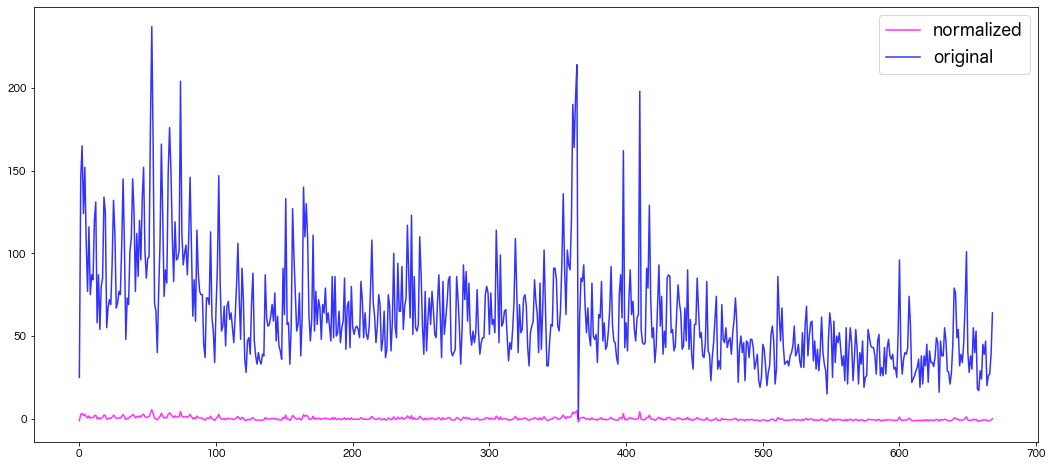

In [111]:
clusters_df_after_std = TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform(X_train)
plt.figure(figsize=(18, 8))
plt.plot(clusters_df_after_std[10] ,c='magenta',alpha=0.8,label="normalized")
plt.plot(clusters_df_after.iloc[:,10].values,c='blue',alpha=0.8,label="original")
plt.legend(fontsize=17)

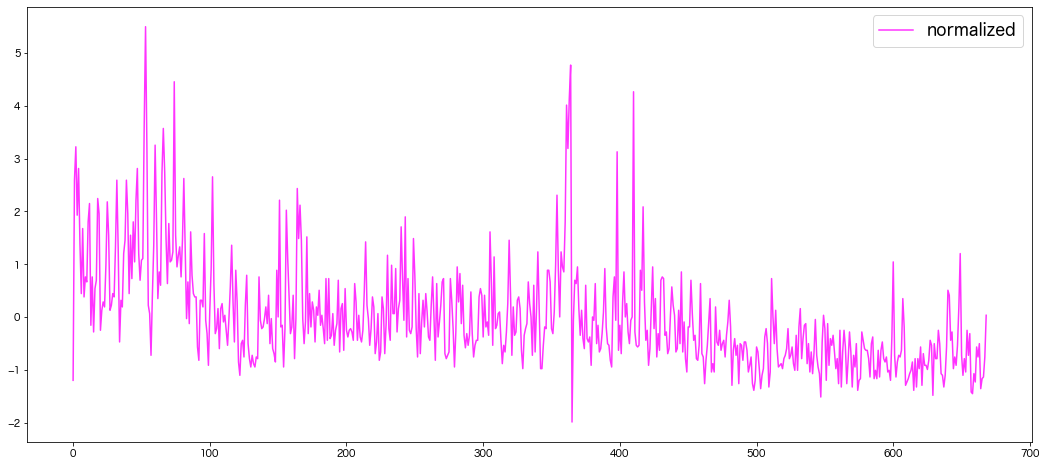

In [112]:
clusters_df_after_std = TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform(X_train)
plt.figure(figsize=(18, 8))
plt.plot(clusters_df_after_std[10] ,c='magenta',alpha=0.8,label="normalized")
# plt.plot(clusters_df_after.iloc[:,0].values,c='blue',alpha=0.8,label="original")
plt.legend(fontsize=17)

In [216]:
distortions = []

#1~10クラスタまで計算
for i in range(2,10):
    print('*'*100)
    print("Start ",i)
    ks = KShape(n_clusters=i, n_init=10, verbose=True, random_state=77)
    #クラスタリングの計算を実行
    ks.fit(X_train)
    #ks.fitするとks.inertia_が得られる
    #inertia_でSSEを取得できる
    distortions.append(ks.inertia_)

plt.plot(range(2,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

****************************************************************************************************
Start  2
Init 1
0.394 --> 0.370 --> 0.291 --> 0.257 --> 0.255 --> 0.256 --> 
Init 2
0.396 --> 0.288 --> 0.262 --> 0.262 --> 
Init 3
0.396 --> 0.288 --> 0.262 --> 0.262 --> 
Init 4
Resumed because of empty cluster
Init 4
0.388 --> 0.291 --> 0.258 --> 0.256 --> 0.257 --> 
Init 5
0.390 --> 0.289 --> 0.262 --> 0.262 --> 
Init 6
0.399 --> 0.400 --> 
Init 7
0.392 --> 0.365 --> 0.271 --> 0.254 --> 0.255 --> 
Init 8
0.398 --> 0.398 --> 0.398 --> 
Init 9
0.396 --> 0.288 --> 0.262 --> 0.262 --> 
****************************************************************************************************
Start  3
Init 1
0.383 --> 0.305 --> 0.257 --> 0.250 --> 0.251 --> 
Init 2
0.389 --> 0.279 --> 0.250 --> 0.250 --> 0.251 --> 
Init 3
Resumed because of empty cluster
Init 3
0.383 --> 0.303 --> 0.258 --> 0.255 --> 0.256 --> 
Init 4
0.388 --> 0.326 --> 0.262 --> 0.250 --> 0.251 --> 
Init 5
0.387 --> 0.386 -->

EmptyClusterError: Cluster assignments lead to at least one empty cluster

In [217]:
distortions

[0.2541214378747778,
 0.24992686685591675,
 0.24490731734975857,
 0.3609846393776357,
 0.3622440776466084]

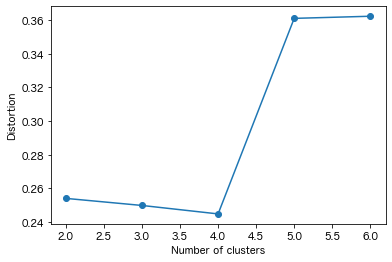

In [221]:
plt.plot(range(2,len(distortions)+2), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [219]:
print(ks.inertia_)

0.3573011760248352


In [113]:
ks = KShape(n_clusters=4, max_iter=100, n_init=100, verbose=True)
ks.fit(X_train)
print(ks.inertia_)
y_pred_shop = ks.fit_predict(X_train)
print(y_pred_shop)

Init 1
0.376 --> 0.370 --> 0.369 --> 0.369 --> 
Init 2
0.378 --> Resumed because of empty cluster
Init 2
0.375 --> 0.309 --> Resumed because of empty cluster
Init 2
Resumed because of empty cluster
Init 2
0.382 --> Resumed because of empty cluster
Init 2
0.375 --> 0.364 --> Resumed because of empty cluster
Init 2
0.380 --> 0.376 --> 0.368 --> Resumed because of empty cluster
Init 2
Resumed because of empty cluster
Init 2
0.373 --> Resumed because of empty cluster
Init 2
0.377 --> Resumed because of empty cluster
Init 2
Resumed because of empty cluster
Init 2
0.377 --> 0.355 --> Resumed because of empty cluster
Init 2
Resumed because of empty cluster
Init 2
0.381 --> 0.382 --> 
Init 3
0.375 --> 0.373 --> 0.374 --> 
Init 4
0.365 --> Resumed because of empty cluster
Init 4
0.377 --> 0.374 --> 0.373 --> 0.373 --> 0.373 --> 0.372 --> 0.371 --> 0.369 --> 0.368 --> 0.366 --> 0.365 --> 0.364 --> 0.362 --> 0.361 --> 0.359 --> 0.358 --> 0.356 --> 0.355 --> 0.354 --> 0.354 --> 0.352 --> 0.351 -->

In [114]:
y_pred_shop

array([3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0])

In [115]:
shopID_sales_clusters_df = pd.DataFrame(clusters_df_after.T.index, columns=['店舗ID'])
shopID_sales_clusters_df['店舗別_売上個数_クラスタ'] = y_pred_shop
shopID_sales_clusters_df['店舗別_売上個数_クラスタ_cat'] = shopID_sales_clusters_df['店舗別_売上個数_クラスタ'].astype(str)
shopID_sales_clusters_df

店舗ID  店舗別_売上個数_クラスタ 店舗別_売上個数_クラスタ_cat
0     0              3                 3
1     1              1                 1
2    10              0                 0
3    13              0                 0
4    14              0                 0
5    15              0                 0
6     2              0                 0
7     5              0                 0
8     6              0                 0
9     7              0                 0
10    8              0                 0
11    9              2                 2
12   11              0                 0
13   12              0                 0
14   16              0                 0
15   17              0                 0
16    3              0                 0
17    4              0                 0

In [116]:

dataset_addfeature_lag_trend_clusters = pd.merge(dataset_addfeature_lag_trend_clusters, shopID_sales_clusters_df, on=['店舗ID'], how='left')

In [117]:
dataset_addfeature_lag_trend_clusters

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
0                          0         NaN         NaN         NaN         NaN   
1                          0         NaN         NaN         NaN         NaN   
2                          0         NaN         NaN         NaN         NaN   
3                          0         NaN         NaN         NaN         NaN   
4                

### 商品ID の 日付ごと 売上個数別 クラスタリング

In [118]:
n_clusters_df = train_merged_data.groupby(['日付', '商品ID'])['売上個数'].sum().reset_index()
n_clusters_df = n_clusters_df.set_index('日付')
n_clusters_df

商品ID  売上個数
日付                       
2018-01-01  1000001   3.0
2018-01-01  1000017   2.0
2018-01-01  1000018   1.0
2018-01-01  1000027   1.0
2018-01-01  1000028   2.0
...             ...   ...
2019-10-31  3400006   1.0
2019-10-31  3400009   1.0
2019-10-31  3400012   1.0
2019-10-31  3500001   1.0
2019-10-31  3500004   1.0

[611795 rows x 2 columns]

In [119]:
n_clusters_df['商品ID'].nunique()

9039

In [120]:
clusters_df_after = pd.DataFrame()
for ID in tqdm(n_clusters_df['商品ID'].unique()):
    clusters_df_cat = n_clusters_df[n_clusters_df['商品ID'] == ID]['売上個数']
    clusters_df_after = pd.concat([clusters_df_after, clusters_df_cat], axis=1)
    clusters_df_after = clusters_df_after.fillna(0)
clusters_df_after.columns = [ID for ID in n_clusters_df['商品ID'].unique()]
# clusters_df_after = clusters_df_after.reset_index()

  0%|          | 0/9039 [00:00<?, ?it/s]

In [ ]:
clusters_df_after.T

In [121]:
X_train = to_time_series_dataset(clusters_df_after.T)
X_train

array([[[3.],
        [8.],
        [4.],
        ...,
        [0.],
        [1.],
        [0.]],

       [[2.],
        [7.],
        [4.],
        ...,
        [1.],
        [0.],
        [0.]],

       [[1.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]]])

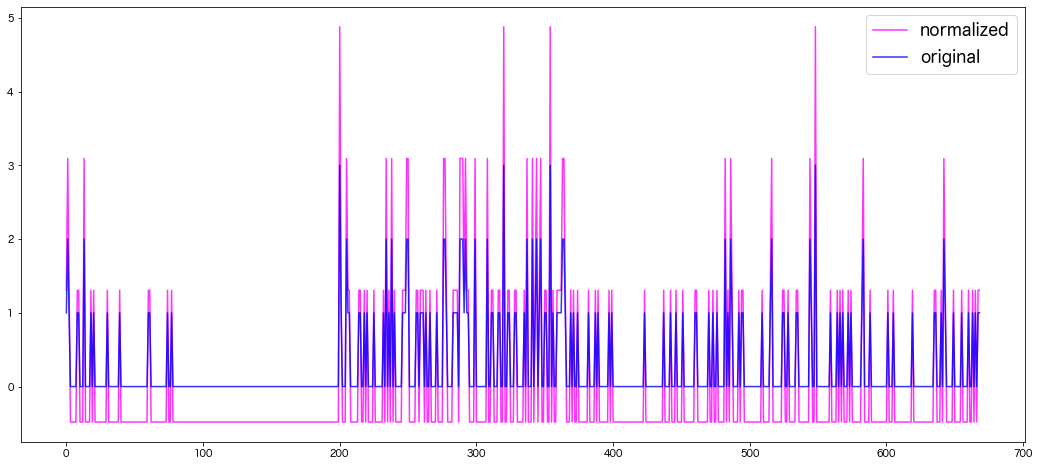

In [122]:
clusters_df_after_std = TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform(X_train)
plt.figure(figsize=(18, 8))
plt.plot(clusters_df_after_std[600] ,c='magenta',alpha=0.8,label="normalized")
plt.plot(clusters_df_after.iloc[:,600].values,c='blue',alpha=0.8,label="original")
plt.legend(fontsize=17)

In [123]:
data_train = np.array(clusters_df_after).T
X_train = to_time_series_dataset(data_train)

print("時系列データの総数 : ",len(data_train))
print("クラスの数 : ", len(np.unique(data_train[:,0])))
print("時系列の長さ : ",len(data_train[0,1:]))

時系列データの総数 :  9039
クラスの数 :  13
時系列の長さ :  668


In [236]:
distortions = []

#1~10クラスタまで計算
for i in range(2,50):
    print("Start ",i)
    ks = KShape(n_clusters=i, n_init=10, verbose=True, random_state=77)
    #クラスタリングの計算を実行
    ks.fit(X_train)
    #ks.fitするとks.inertia_が得られる
    #inertia_でSSEを取得できる
    distortions.append(ks.inertia_)

Start  2
Init 1
0.319 --> 0.317 --> 0.317 --> 0.316 --> 0.316 --> 0.316 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.315 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 0.314 --> 
Init 2
0.329 --> 0.329 --> 0.326 --> 0.322 --> 0.320 --> 0.319 --> 0.319 --> 0.319 --> 0.319 --> 
Init 3
0.307 --> 0.310 --> 
Init 4
0.327 --> 0.320 --> 0.317 --> 0.316 --> 0.314 --> 0.313 --> 0.312 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.311 --> 0.310 --> 0.310 --> 0.310 --> 0.310 --> 0.310 --> 0.310 --> 
Init 5
0.338 --> 0.326 --> 0.323 --> 0.321 --> 0.320 --> 0.317 --> 0.314 --> 0.313 --> 0.

EmptyClusterError: Cluster assignments lead to at least one empty cluster

In [237]:
distortions

[0.3066093253766616,
 0.2989723196063154,
 0.29381983384034865,
 0.28943871631556806,
 0.2845686041920366,
 0.2750676510688137,
 0.2731866489990337,
 0.27218607059664246,
 0.27029016076819046,
 0.2629326771843145,
 0.26921226942433396,
 0.26449194755775474,
 0.2628462251452486,
 0.26562108581601895,
 0.2631994418182567,
 0.2597372651659168,
 0.2625123879064878,
 0.2612003453365889,
 0.2613084953294466,
 0.2579710740471942,
 0.25654404014392773,
 0.2574824254797998,
 0.25787699192954977,
 0.25151417375778745,
 0.25638686072543887,
 0.2567369909352186,
 0.2557335855110107,
 0.25168691501501705,
 0.2475778053034905,
 0.25429153806056415]

ValueError: x and y must have same first dimension, but have shapes (48,) and (30,)

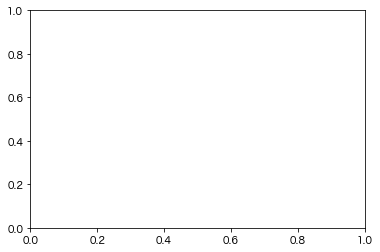

In [238]:
plt.plot(range(2,50), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

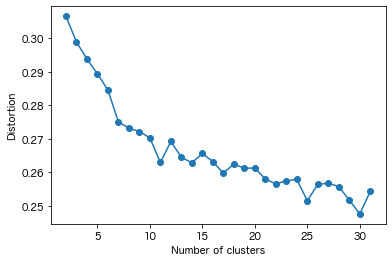

In [239]:
plt.plot(range(2,len(distortions)+2), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [124]:
#クラスタ数 11
ks = KShape(n_clusters=11, max_iter=100, n_init=100, verbose=True)
ks.fit(X_train)
print(ks.inertia_)
y_pred_item = ks.fit_predict(X_train)
print(y_pred_item)

Init 1
0.294 --> 0.286 --> 0.282 --> 0.280 --> 0.279 --> 0.280 --> 
Init 2
0.290 --> 0.287 --> 0.287 --> 
Init 3
0.289 --> 0.289 --> 0.285 --> 0.281 --> 0.280 --> 0.299 --> 
Init 4
0.284 --> 0.279 --> 0.281 --> 
Init 5
0.289 --> 0.290 --> 
Init 6
0.288 --> 0.286 --> 0.289 --> 
Init 7
0.291 --> 0.285 --> 0.283 --> 0.281 --> 0.283 --> 
Init 8
0.293 --> 0.285 --> 0.282 --> 0.281 --> 0.281 --> 
Init 9
0.283 --> 0.284 --> 
Init 10
0.298 --> 0.287 --> 0.285 --> 0.287 --> 
Init 11
0.289 --> 0.274 --> 0.279 --> 
Init 12
0.284 --> 0.274 --> 0.272 --> 0.275 --> 
Init 13
0.297 --> 0.295 --> 0.293 --> 0.294 --> 
Init 14
0.301 --> 0.287 --> 0.290 --> 
Init 15
0.287 --> 0.281 --> 0.282 --> 
Init 16
0.291 --> 0.284 --> 0.285 --> 
Init 17
0.295 --> 0.288 --> 0.284 --> 0.285 --> 
Init 18
0.294 --> 0.283 --> 0.277 --> 0.276 --> 0.276 --> 
Init 19
0.290 --> 0.281 --> 0.275 --> 0.276 --> 
Init 20
0.286 --> 0.281 --> 0.281 --> 
Init 21
0.287 --> 0.282 --> 0.279 --> 0.278 --> 0.276 --> 0.276 --> 
Init 22
0.

In [125]:
itemID_sales_clusters_df = pd.DataFrame(clusters_df_after.T.index, columns=['商品ID'])
itemID_sales_clusters_df['商品別_売上個数_クラスタ'] = y_pred_item
itemID_sales_clusters_df['商品別_売上個数_クラスタ_cat'] = itemID_sales_clusters_df['商品別_売上個数_クラスタ'].astype(str)
itemID_sales_clusters_df

商品ID  商品別_売上個数_クラスタ 商品別_売上個数_クラスタ_cat
0     1000001              6                 6
1     1000017              6                 6
2     1000018              4                 4
3     1000027              9                 9
4     1000028              5                 5
...       ...            ...               ...
9034  1201333              9                 9
9035  1300369              9                 9
9036  1700230              9                 9
9037  2100176              9                 9
9038  2400101              9                 9

[9039 rows x 3 columns]

In [126]:
dataset_addfeature_lag_trend_clusters = pd.merge(dataset_addfeature_lag_trend_clusters, itemID_sales_clusters_df, on=['商品ID'], how='left')

In [127]:
dataset_addfeature_lag_trend_clusters

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
0                          0         NaN         NaN         NaN         NaN   
1                          0         NaN         NaN         NaN         NaN   
2                          0         NaN         NaN         NaN         NaN   
3                          0         NaN         NaN         NaN         NaN   
4                

In [128]:
dataset_addfeature_lag_trend_clusters.to_pickle('./inputs/dataset_addfeature_lag_trend_clusters.pickle')

In [129]:
# dataset_addfeature_lag_trend_clusters = pd.read_pickle('./inputs/dataset_addfeature_lag_trend_clusters.pickle')

## 店舗IDごと 商品売上比率 ポートフォリオ

In [130]:
dataset_addfeature_lag_trend_clusters_portfolio = dataset_addfeature_lag_trend_clusters.copy()

In [131]:
df = pd.DataFrame()

for ID in tqdm(dataset_addfeature_lag_trend_clusters_portfolio['店舗ID'].unique()):
    group = train_merged_data.groupby(['店舗ID', '商品カテゴリ名'])['売上個数'].sum().reset_index()
    _df = group[group['店舗ID'] == ID]
    _df['売上個数_比率'] = _df['売上個数'] / _df.T.sum(axis=1)['売上個数']
    _df = _df.drop(columns='売上個数')
    df = pd.concat([df, _df])
dataset_addfeature_lag_trend_clusters_portfolio = pd.merge(dataset_addfeature_lag_trend_clusters_portfolio, df, on=['店舗ID','商品カテゴリ名'], how='left')

  0%|          | 0/18 [00:00<?, ?it/s]

In [132]:
dataset_addfeature_lag_trend_clusters_portfolio

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0            0    0  1000001   6.0     2018        01  2018      1         0   
1            0    0  1000002   2.0     2018        01  2018      1         0   
2            0    0  1000003   0.0     2018        01  2018      1         0   
3            0    0  1000004   1.0     2018        01  2018      1         0   
4            0    0  1000005   8.0     2018        01  2018      1         0   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
0                  2   0.866025  5.000000e-01      100           映画 - DVD   
1                  2   0.866025  5.000000e-01      100           映画 - DVD   
2                  2   0.866025  5.000000e-01      100           映画 - DVD   
3                  2   0.866025  5.000000e-01      100           映画 - DVD   
4                  2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
0                映画           DVD         None       2733            4186   
1                映画           DVD         None       2733            4186   
2                映画           DVD         None       2733            4186   
3                映画           DVD         None       2733            4186   
4                映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
0                  2733             NaN                     0   
1                  2733             NaN                     0   
2                  2733             NaN                     0   
3                  2733             NaN                     0   
4                  2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
0                          0         NaN         NaN         NaN         NaN   
1                          0         NaN         NaN         NaN         NaN   
2                          0         NaN         NaN         NaN         NaN   
3                          0         NaN         NaN         NaN         NaN   
4                

In [133]:
group = train_merged_data.groupby('店舗ID')['売上個数'].sum().reset_index().sort_values('売上個数').reset_index(drop=True)
group['店舗売上個数_順位'] = group['売上個数'].rank(ascending=False)
group.drop('売上個数', axis=1,inplace=True)
dataset_addfeature_lag_trend_clusters_portfolio = pd.merge(dataset_addfeature_lag_trend_clusters_portfolio, group, on=['店舗ID'], how='left')

## 欠損値を0で埋める

In [134]:
# dataset3 = dataset3.fillna(0)
# dataset3.head()

# 特徴量を追加したデータフレームを保存

In [135]:
dataset_addfeature_lag_trend_clusters[dataset_addfeature_lag_trend_clusters.月ブロック >= 12]

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
331704      12    0  1000001   2.0     2019        01  2019      1        12   
331705      12    0  1000002   0.0     2019        01  2019      1        12   
331706      12    0  1000003   0.0     2019        01  2019      1        12   
331707      12    0  1000004   0.0     2019        01  2019      1        12   
331708      12    0  1000005   1.0     2019        01  2019      1        12   
...        ...  ...      ...   ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001   NaN     2019        12  2019     12        23   
1655024     23   14  3500001   NaN     2019        12  2019     12        23   
1655025     23   15  3500001   NaN     2019        12  2019     12        23   
1655026     23   16  3500001   NaN     2019        12  2019     12        23   
1655027     23   17  3500001   NaN     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin 商品カテゴリID            商品カテゴリ名  \
331704             2   0.866025  5.000000e-01      100           映画 - DVD   
331705             2   0.866025  5.000000e-01      100           映画 - DVD   
331706             2   0.866025  5.000000e-01      100           映画 - DVD   
331707             2   0.866025  5.000000e-01      100           映画 - DVD   
331708             2   0.866025  5.000000e-01      100           映画 - DVD   
...              ...        ...           ...      ...                ...   
1655023            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655024            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655025            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655026            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   
1655027            0   1.000000 -2.449294e-16      350  本 - オーディオブック_タイプB   

        商品カテゴリ_type1 商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  \
331704           映画           DVD         None       2733            4186   
331705           映画           DVD         None       2733            4186   
331706           映画           DVD         None       2733            4186   
331707           映画           DVD         None       2733            4186   
331708           映画           DVD         None       2733            4186   
...              ...          ...          ...        ...             ...   
1655023           本      オーディオブック         タイプB         76             445   
1655024           本      オーディオブック         タイプB         76             445   
1655025           本      オーディオブック         タイプB         76             445   
1655026           本      オーディオブック         タイプB         76             445   
1655027           本      オーディオブック         タイプB         76             445   

         カテゴリtype2内_商品数  カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  \
331704             2733             NaN                     0   
331705             2733             NaN                     0   
331706             2733             NaN                     0   
331707             2733             NaN                     0   
331708             2733             NaN                     0   
...                 ...             ...                   ...   
1655023             357           165.0                     0   
1655024             357           165.0                     0   
1655025             357           165.0                     0   
1655026             357           165.0                     0   
1655027             357           165.0                     0   

         商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  \
331704                     0    0.000000         2.0         0.0         1.0   
331705                     0    0.000000         0.0         1.0         2.0   
331706                     0    2.000000         0.0         0.0         1.0   
331707                     0    0.000000         0.0         0.0         0.0   
331708           

In [136]:
dataset_addfeature_lag_trend_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1655028 entries, 0 to 1655027
Columns: 475 entries, 月ブロック to 商品別_売上個数_クラスタ_cat
dtypes: float16(432), float64(16), int64(13), int8(2), object(12)
memory usage: 1.9+ GB


In [137]:
# dataset_addfeature_lag_trend_clusters.to_pickle('./inputs/dataset_addfeature_lag_trend_clusters.pickle')

# 説明変数の前処理

In [222]:
#数値の説明変数のリストを作成
num_feats = dataset_addfeature_lag_trend.dtypes[dataset_addfeature_lag_trend.dtypes != "object" ].index
print(num_feats)

Index(['月ブロック', '売上個数', 'year', 'month', 'holiday_cnt', 'month_cos',
       'month_sin', '売上個数_lag_1', '売上個数_lag_2', '売上個数_lag_3', '売上個数_lag_6',
       '売上個数_lag_12', 'date_avg_売上個数_lag_1', 'date_avg_売上個数_lag_2',
       'date_avg_売上個数_lag_3', 'date_avg_売上個数_lag_6', 'date_avg_売上個数_lag_12',
       'date_item_avg_売上個数_lag_1', 'date_item_avg_売上個数_lag_2',
       'date_item_avg_売上個数_lag_3', 'date_item_avg_売上個数_lag_6',
       'date_item_avg_売上個数_lag_12', 'date_shop_avg_売上個数_lag_1',
       'date_shop_avg_売上個数_lag_2', 'date_shop_avg_売上個数_lag_3',
       'date_shop_avg_売上個数_lag_6', 'date_shop_avg_売上個数_lag_12',
       'date_catname_avg_売上個数_lag_1', 'date_catname_avg_売上個数_lag_2',
       'date_catname_avg_売上個数_lag_3', 'date_catname_avg_売上個数_lag_6',
       'date_catname_avg_売上個数_lag_12', 'date_cattype1_avg_売上個数_lag_1',
       'date_cattype1_avg_売上個数_lag_2', 'date_cattype1_avg_売上個数_lag_3',
       'date_cattype1_avg_売上個数_lag_6', 'date_cattype1_avg_売上個数_lag_12',
       'date_cattype2_avg_売上個数_lag_1', 'd

<AxesSubplot:>

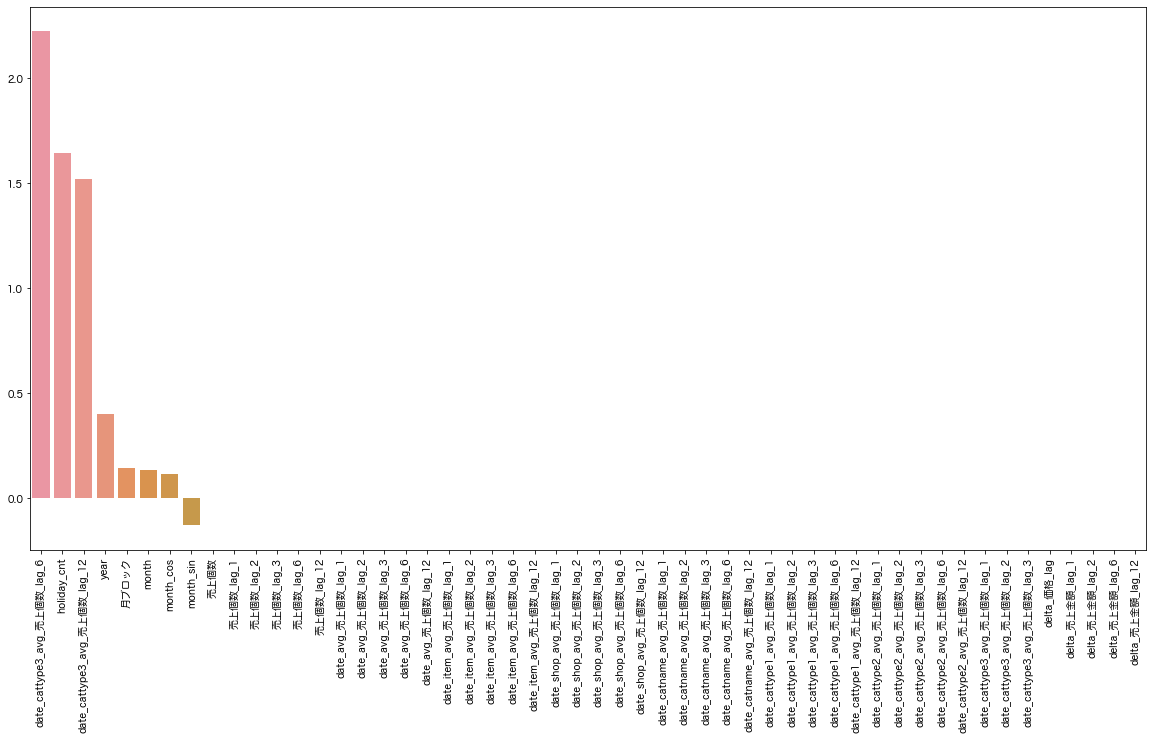

In [223]:
#各説明変数の歪度を計算
skewed_feats = dataset_addfeature_lag_trend[num_feats].apply(lambda x: x.skew()).sort_values(ascending = False)

#グラフ化
plt.figure(figsize=(20,10))
plt.xticks(rotation='90')
sns.barplot(x=skewed_feats.index, y=skewed_feats)

In [224]:
#歪度の絶対値が0.5より大きい変数だけに絞る
skewed_feats_over = skewed_feats[abs(skewed_feats) > 0.5].index

#各変数の最小値を表示
for i in skewed_feats_over:
    print(min(dataset_addfeature_lag_trend[i]))

nan
0
nan


In [225]:
skewed_feats_over

Index(['date_cattype3_avg_売上個数_lag_6', 'holiday_cnt',
       'date_cattype3_avg_売上個数_lag_12'],
      dtype='object')

In [226]:
dataset_addfeature_lag_trend.date_cattype3_avg_売上個数_lag_12

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
             ...   
1655023    1.077148
1655024    1.077148
1655025    1.077148
1655026    1.077148
1655027    1.077148
Name: date_cattype3_avg_売上個数_lag_12, Length: 1655028, dtype: float16

## 対数変換した説明変数を追加

['月ブロック', '売上個数_lag_1', '売上個数_lag_2', '売上個数_lag_3', '売上個数_lag_6', '売上個数_lag_12', 'date_avg_売上個数_lag_1', 'date_avg_売上個数_lag_2', 'date_avg_売上個数_lag_3', 'date_avg_売上個数_lag_6', 'date_avg_売上個数_lag_12', 'date_item_avg_売上個数_lag_1', 'date_item_avg_売上個数_lag_2', 'date_item_avg_売上個数_lag_3', 'date_item_avg_売上個数_lag_6', 'date_item_avg_売上個数_lag_12', 'date_shop_avg_売上個数_lag_1', 'date_shop_avg_売上個数_lag_2', 'date_shop_avg_売上個数_lag_3', 'date_shop_avg_売上個数_lag_6', 'date_shop_avg_売上個数_lag_12', 'date_catname_avg_売上個数_lag_1', 'date_cattype1_avg_売上個数_lag_1', 'date_cattype1_avg_売上個数_lag_2', 'date_cattype1_avg_売上個数_lag_3', 'date_cattype1_avg_売上個数_lag_6', 'date_cattype1_avg_売上個数_lag_12', 'date_cattype2_avg_売上個数_lag_1', 'date_cattype2_avg_売上個数_lag_2', 'date_cattype2_avg_売上個数_lag_3', 'date_cattype2_avg_売上個数_lag_6', 'date_cattype2_avg_売上個数_lag_12', 'date_cattype3_avg_売上個数_lag_1', 'date_cattype3_avg_売上個数_lag_2', 'date_cattype3_avg_売上個数_lag_3', 'date_cattype3_avg_売上個数_lag_6', 'date_cattype3_avg_売上個数_lag_12', 'year',

ValueError: min() arg is an empty sequence

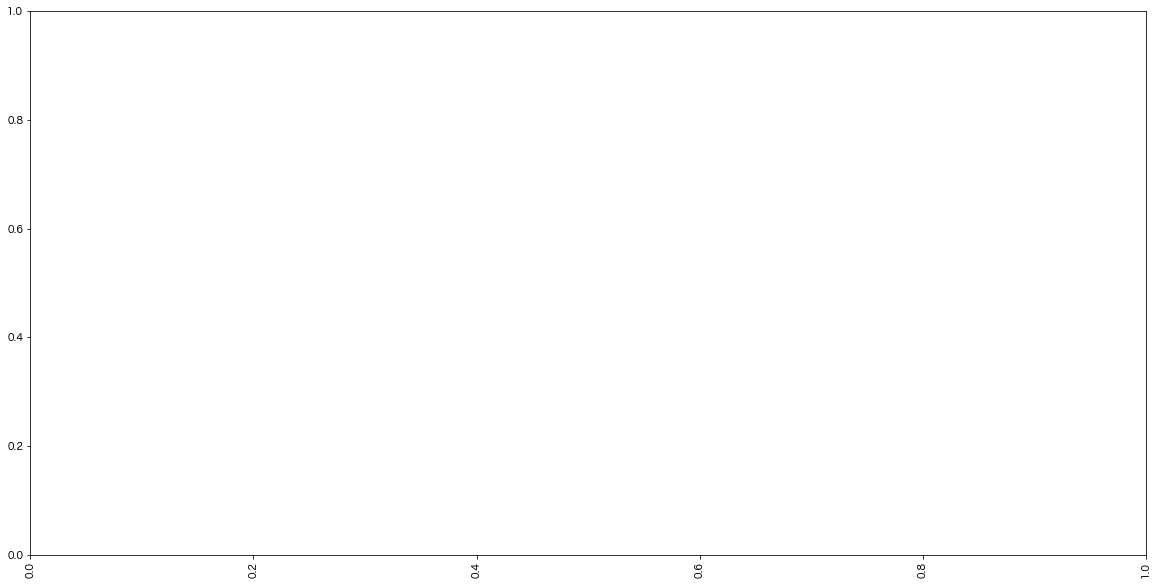

In [35]:
X_data_log, num_col_feat_list, pt = logarithmic_transformation(X_data)

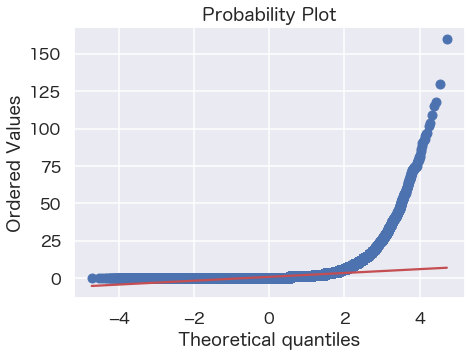

In [88]:
import scipy.stats as stats
 
sns.set(font="Hiragino Maru Gothic Pro",context="talk")
fig = plt.subplots(figsize=(7,5))
 
stats.probplot(y_train, dist="norm", plot=plt)
plt.show()

In [85]:
y_train_log = np.log1p(y_train)

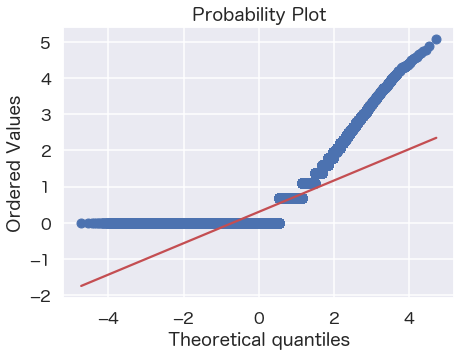

In [87]:
import scipy.stats as stats
 
sns.set(font="Hiragino Maru Gothic Pro",context="talk")
fig = plt.subplots(figsize=(7,5))
 
stats.probplot(y_train_log, dist="norm", plot=plt)
plt.show()

train_y
歪度: nan
尖度: nan
np.exp(train_y_log)
歪度: nan
尖度: nan


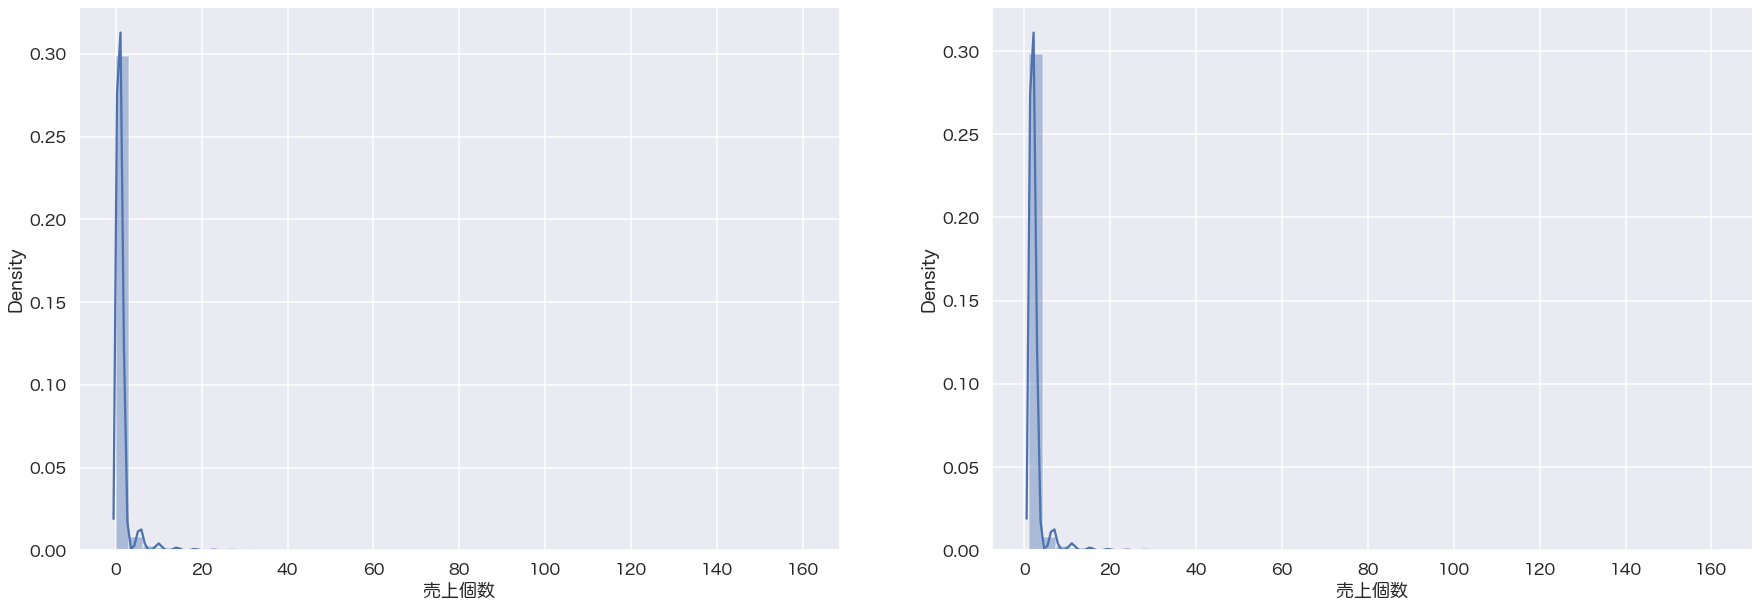

In [94]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 10])

sns.distplot(y_train, ax=ax1)
#歪度と尖度を計算
print('train_y')
print("歪度: %f" % y_train.skew())
print("尖度: %f" % y_train.kurt())

print('=============')

sns.distplot(np.exp(y_train_log), ax=ax2)
print('np.exp(train_y_log)')
#歪度と尖度を計算
print("歪度: %f" % np.exp(y_train_log).skew())
print("尖度: %f" % np.exp(y_train_log).kurt())